On se propose dans ce mini-projet d'entrainer plusieurs modèles pour la tâche de *sentiment analysis* sur le dataset IMDB.

In [1]:
## Library imports
import random
import os
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Presentation de l'étude

## Tâche de Sentiment Analysis

La *sentiment analysis* est une tâche qui consiste à identifier et classer les émotions, opinions ou attitudes exprimées dans un texte, critiques, séquences textuellse. Le principe est de tenter de prédire si une séquenvce de texte exprime un sentiment positif ou négatif (ou parfois neutre, selon les cas).

Dans le cadre de ce projet, la *sentiment analysis* appliquée aux critiques de films du dataset IMDb sont utilisées afin d'entraîner plusieurs modèles capables de prédire le sentiment derrière ces critiques, en se basant uniquement sur le texte.

## Présentation du jeu de données IMDB

IMDB est un jeu de données pour la classification binaire des sentiments. Il foutnit un ensemble de 25 000 critiques de films pour l'entraînement et 25 000 pour les tests. Des données non étiquetées supplémentaires sont également disponibles. Les formats de texte brut et de sac de mots déjà traités sont fournis.

Ces critiques sont organisées en deux catégories principales : positives et négatives, permettant une classification binaire des sentiments.

Les critiques d'entraînement et de test sont équilibrées, contenant chacune un nombre égal de critiques positives et négatives.

Les critiques varient en longueur, allant de quelques phrases à plusieurs paragraphes, les longueurs des séquences de textes sont donc relativement variables.


Commençons dans un premier temps par extraire le jeu de données via le site https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [2]:
import os
import requests
import tarfile

# URL du dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Nom du fichier d'archive
archive_name = "aclImdb_v1.tar.gz"
dataset_folder = "aclImdb"

# Fonction pour télécharger le fichier
def download_dataset(url, archive_name):
    if not os.path.exists(archive_name):
        print("Téléchargement en cours...")
        response = requests.get(url, stream=True)
        with open(archive_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Fichier téléchargé : {archive_name}")
    else:
        print(f"Le fichier {archive_name} existe déjà.")

# Fonction pour extraire le fichier
def extract_dataset(archive_name, extract_path):
    if not os.path.exists(extract_path):
        print("Extraction en cours...")
        with tarfile.open(archive_name, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"Dataset extrait dans le dossier : {extract_path}")
    else:
        print(f"Le dossier {extract_path} existe déjà.")

# Télécharger et extraire le dataset
download_dataset(url, archive_name)
extract_dataset(archive_name, dataset_folder)

# Vérifier les fichiers extraits
print("Contenu du dossier extrait :")
for root, dirs, files in os.walk(dataset_folder):
    for name in files[:5]:  # Afficher seulement les 5 premiers fichiers
        print(os.path.join(root, name))

Téléchargement en cours...
Fichier téléchargé : aclImdb_v1.tar.gz
Extraction en cours...
Dataset extrait dans le dossier : aclImdb
Contenu du dossier extrait :
aclImdb/aclImdb/imdb.vocab
aclImdb/aclImdb/README
aclImdb/aclImdb/imdbEr.txt
aclImdb/aclImdb/train/urls_pos.txt
aclImdb/aclImdb/train/unsupBow.feat
aclImdb/aclImdb/train/urls_neg.txt
aclImdb/aclImdb/train/urls_unsup.txt
aclImdb/aclImdb/train/labeledBow.feat
aclImdb/aclImdb/train/unsup/42956_0.txt
aclImdb/aclImdb/train/unsup/35752_0.txt
aclImdb/aclImdb/train/unsup/47309_0.txt
aclImdb/aclImdb/train/unsup/16968_0.txt
aclImdb/aclImdb/train/unsup/10657_0.txt
aclImdb/aclImdb/train/neg/29_4.txt
aclImdb/aclImdb/train/neg/6743_1.txt
aclImdb/aclImdb/train/neg/1728_3.txt
aclImdb/aclImdb/train/neg/3094_2.txt
aclImdb/aclImdb/train/neg/4508_2.txt
aclImdb/aclImdb/train/pos/2624_7.txt
aclImdb/aclImdb/train/pos/7419_10.txt
aclImdb/aclImdb/train/pos/3954_9.txt
aclImdb/aclImdb/train/pos/3943_10.txt
aclImdb/aclImdb/train/pos/10206_10.txt
aclImdb/ac

In [3]:
import os
import tensorflow as tf

dataset_folder = "aclImdb/aclImdb"

# Chemins vers les dossiers contenant les données
train_dir = os.path.join(dataset_folder, "train")
test_dir = os.path.join(dataset_folder, "test")

# Fonction pour charger les données
def load_imdb_data(data_dir):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return texts, labels

# Chargement des données d'entraînement et de test
train_texts, train_labels = load_imdb_data(train_dir)
test_texts, test_labels = load_imdb_data(test_dir)

print(f"Nombre de critiques dans l'ensemble d'entraînement : {len(train_texts)}")
print(f"Nombre de critiques dans l'ensemble de test : {len(test_texts)}")

# Exemple de texte positif et négatif
print("\nExemple de critique positive :")
print(train_texts[train_labels.index(1)][:300])  # Affiche les 300 premiers caractères d'une critique positive

print("\nExemple de critique négative :")
print(train_texts[train_labels.index(0)][:300])  # Affiche les 300 premiers caractères d'une critique négative

Nombre de critiques dans l'ensemble d'entraînement : 25000
Nombre de critiques dans l'ensemble de test : 25000

Exemple de critique positive :
In this film we have the fabulous opportunity to see what happened to Timon and Pumbaa in the film when they are not shown - which is a lot! This film even goes back to before Simba and (presumbably) just after the birth of Kiara. <br /><br />Quite true to the first film, "Lion King 1/2 (or Lion Kin

Exemple de critique négative :
I cannot stay indifferent to Lars van Trier's films. I consider 'Breaking the Waves' nothing less than a masterpiece. I loved 'Dancer in the Night'. I admired the idea in 'Dogville' but the overall exercise looked to me too dry and too theatrical, less cinema. 'Europa' which I see only now was a fam


Les premières critiques avec leurs labels correspondants (1 pour positif et 0 pour négatif) sont affichées.

## Prétraitement des données

### Exploration des données

Pour débuter notre analyse, commençons par une exploration des données. Une manière visuelle et intuitive d'examiner le contenu textuel d'un dataset est de générer un word cloud, une représentation graphique où la taille des mots est proportionnelle à leur fréquence d’apparition dans un corpus de textes donné. Cela permet de repérer rapidement les termes les plus utilisés dans les critiques.

En créant des word clouds pour les critiques positives et négatives, nous pouvons identifier les différences lexicales entre les deux catégories de critiques, positives ou négatives, ce qui nous donne un aperçu des mots qui influencent les différents sentiments exprimés.

In [4]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Télécharger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour créer un corpus basé sur les labels
def create_corpus_by_label(texts, labels, target_label):
    return " ".join([texts[i] for i in range(len(labels)) if labels[i] == target_label])

# Créer les corpus pour les critiques positives et négatives
positive_corpus = create_corpus_by_label(train_texts, train_labels, target_label=1)
negative_corpus = create_corpus_by_label(train_texts, train_labels, target_label=0)

# Fonction pour calculer les mots les plus fréquents
def most_frequent_words(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Calculer les 10 mots les plus fréquents pour chaque catégorie
positive_top_words = most_frequent_words(positive_corpus, top_n=10)
negative_top_words = most_frequent_words(negative_corpus, top_n=10)

# Affichage des résultats
print("10 mots les plus fréquents dans les critiques positives :")
for word, count in positive_top_words:
    print(f"{word}: {count}")

print("\n10 mots les plus fréquents dans les critiques négatives :")
for word, count in negative_top_words:
    print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


10 mots les plus fréquents dans les critiques positives :
/><br: 24617
film: 14641
movie: 13516
one: 11668
like: 8321
good: 6081
great: 5504
see: 5400
really: 5259
would: 5240

10 mots les plus fréquents dans les critiques négatives :
/><br: 26318
movie: 17371
film: 13136
one: 10812
like: 10458
even: 7352
would: 6787
good: 5845
really: 5806
bad: 5335


Les br et />  proviennent des balises HTML incluses dans les critiques du dataset IMDb. Ces balises sont utilisées pour indiquer des sauts de ligne ou des séparations de paragraphes dans le texte brut. Elles  apparaissent dans les mots les plus fréquents car elles sont souvent présentes dans les critiques.

Ces balises sont considérées comme des mots par le tokenizer dont on parlera plus tard.
Elles faussent donc les statistiques en apparaissant parmi les mots les plus fréquents.
Le bruit qu'apportent ces balises dans les données peut introduire des relations non informatives dans le modèle, et donc fausser notre étude.

De plus les phrases contiennent aussi de multipe mots inutiles. En français par exemple toutes les phrase vont contenir des mots comme "de" "le", "la" ect.. C'est la même choses en anglais. Ces mots n'apporte aucune information utile dans le cadre de la tâche de sentiment analisys il est donc préférable de les enelver. On utilise la liste stop_word de la libraire nltk qui contient une liste assez exhaustives des mots à supprimer en anglais.

Nous devons donc supprimer ces balises et nettoyer le text brut. Cela pourrait détourner le modèle de l'apprentissage de rélations pertinentes entre les mots et sentiments de celui qui écrit la critique. Cela pourrait aussi conduire à une baisse de précision. Enfin, lors de la phase de tokenizing, chaque mot inutile comme les balises html réduit la place disponible dans le vocabulaire pour les mots pertinents. Nous y reviendrons juste après.

In [5]:
import re
# Fonction de nettoyage
def clean_text(text):
    # Supprimer les balises HTML
    text = re.sub(r"<.*?>", " ", text)
    # Supprimer les caractères non alphabétiques (optionnel)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # Réduire les espaces multiples en un seul espace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Nettoyer toutes les critiques d'entraînement et de test
train_texts_cleaned = [clean_text(text) for text in train_texts]
test_texts_cleaned = [clean_text(text) for text in test_texts]

# Fonction pour recalculer les mots les plus fréquents après nettoyage
def most_frequent_words_cleaned(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Recréer les corpus nettoyés pour critiques positives et négatives
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# Calculer les 10 mots les plus fréquents après nettoyage
positive_top_words_cleaned = most_frequent_words_cleaned(positive_corpus_cleaned, top_n=10)
negative_top_words_cleaned = most_frequent_words_cleaned(negative_corpus_cleaned, top_n=10)

# Afficher les résultats après nettoyage
print("10 mots les plus fréquents dans les critiques positives (nettoyées) :")
for word, count in positive_top_words_cleaned:
    print(f"{word}: {count}")

print("\n10 mots les plus fréquents dans les critiques négatives (nettoyées) :")
for word, count in negative_top_words_cleaned:
    print(f"{word}: {count}")

10 mots les plus fréquents dans les critiques positives (nettoyées) :
film: 20372
movie: 18860
one: 13496
like: 9038
good: 7703
story: 6715
time: 6491
great: 6409
well: 6408
see: 6016

10 mots les plus fréquents dans les critiques négatives (nettoyées) :
movie: 24712
film: 18733
one: 13023
like: 11238
even: 7691
good: 7397
bad: 7374
would: 6902
really: 6262
time: 6195


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


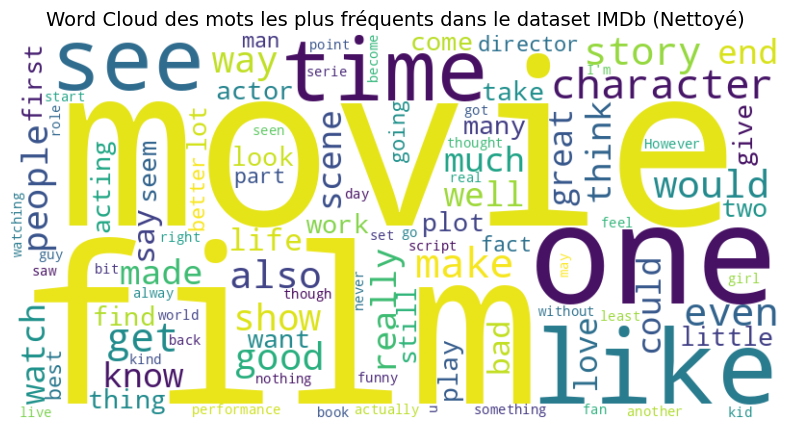

In [6]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Télécharger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour créer un corpus combiné à partir des critiques
def create_corpus(texts):
    # Fusionner toutes les critiques en un seul grand texte
    return " ".join(texts)

# Générer le corpus à partir des textes nettoyés d'entraînement
corpus_cleaned = create_corpus(train_texts_cleaned)

# Génération du WordCloud à partir des données nettoyées
wordcloud_cleaned = WordCloud(
    stopwords=stop_words,  # Exclure les stopwords
    background_color="white",  # Couleur de fond
    max_words=100,  # Nombre maximum de mots à afficher
    width=800,  # Largeur de l'image
    height=400  # Hauteur de l'image
).generate(corpus_cleaned)

# Affichage du WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des mots les plus fréquents dans le dataset IMDb (Nettoyé)", fontsize=14)
plt.show()

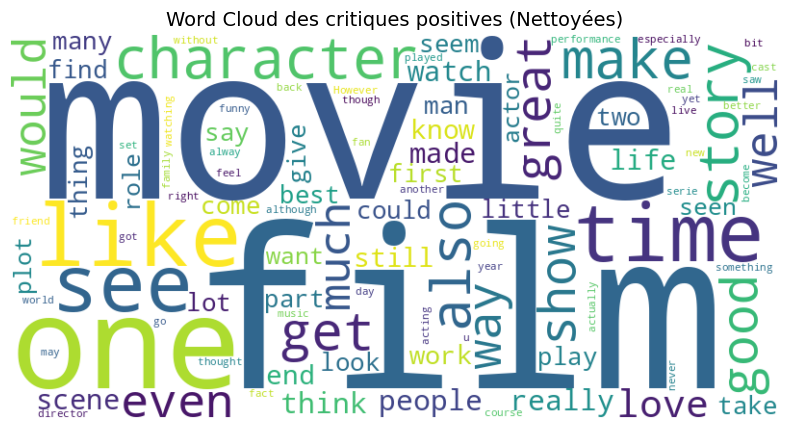

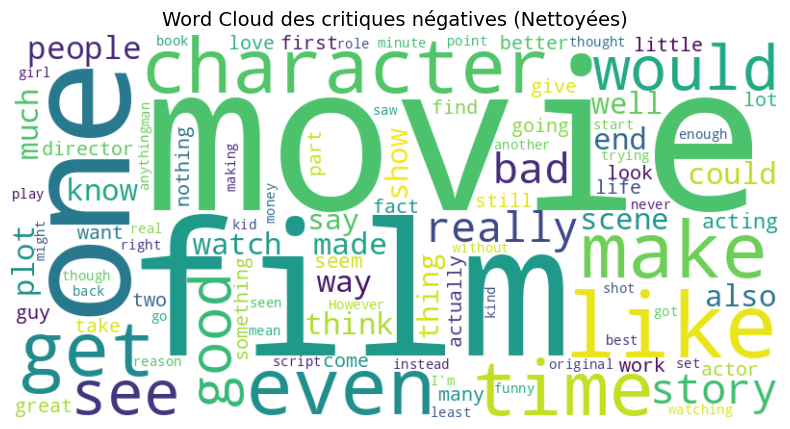

In [7]:
# Création des corpus pour critiques positives et négatives (nettoyées)
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# Génération des WordClouds
def generate_wordcloud(corpus, title, stopwords, width=800, height=400):
    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        max_words=100,
        width=width,
        height=height
    ).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# WordCloud pour critiques positives (nettoyées)
generate_wordcloud(positive_corpus_cleaned, "Word Cloud des critiques positives (Nettoyées)", stop_words)

# WordCloud pour critiques négatives (nettoyées)
generate_wordcloud(negative_corpus_cleaned, "Word Cloud des critiques négatives (Nettoyées)", stop_words)

Certains mots sont très fréquents au point d'apparaitre aussi bien dans les critiques positives que négatives. Ces mots tels que "film", "movie" ou même "like" sont spécifiques au domaine cinématographique de notre étude, et le "like" ici se réfère à l'adverbe de comparaison. En somme, il est tout à fait normal que ces mots se retrouvent dans les deux catégories de critiques.

Cependant, certains mots qui traduisent réellement un sentiment se retrouvent seulement dans une des deux catégories de critiques. Citons par exemple le mot "bad", traduisant un sentiment négatif, et se retrouvant bien parmi les mots les plus fréquents dans les catégories négatives, et non positives. Cela est encourageant pour notre, puisque cela signifie qu'il y a bien des différences lexicales entre les catégories, et que certains mots vont fortement influencer les différents sentiments exprimés.

Longueur moyenne des critiques d'entraînement (nettoyées) : 232.39 mots
Longueur moyenne des critiques de test (nettoyées) : 227.14 mots
Proportion des critiques d'entraînement plus longues que 200 mots (nettoyées) : 41.09%
Proportion des critiques de test plus longues que 200 mots (nettoyées) : 40.01%


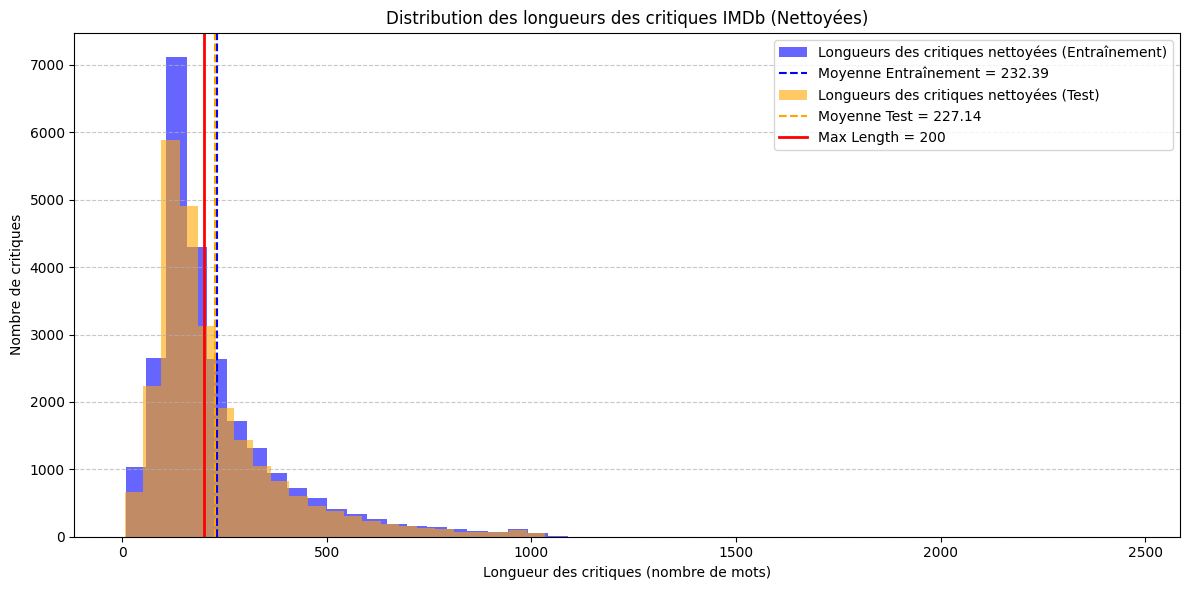

In [8]:


# Calculer la longueur de chaque critique nettoyée
train_lengths_cleaned = [len(text.split()) for text in train_texts_cleaned]
test_lengths_cleaned = [len(text.split()) for text in test_texts_cleaned]

# Calculer la longueur moyenne des critiques nettoyées
average_train_length_cleaned = sum(train_lengths_cleaned) / len(train_lengths_cleaned)
average_test_length_cleaned = sum(test_lengths_cleaned) / len(test_lengths_cleaned)

# Afficher les résultats
print(f"Longueur moyenne des critiques d'entraînement (nettoyées) : {average_train_length_cleaned:.2f} mots")
print(f"Longueur moyenne des critiques de test (nettoyées) : {average_test_length_cleaned:.2f} mots")

# Vérifier la proportion des critiques plus longues que max_length
max_length = 200  # Longueur maximale définie
train_above_max_cleaned = sum(1 for length in train_lengths_cleaned if length > max_length) / len(train_lengths_cleaned) * 100
test_above_max_cleaned = sum(1 for length in test_lengths_cleaned if length > max_length) / len(test_lengths_cleaned) * 100

print(f"Proportion des critiques d'entraînement plus longues que {max_length} mots (nettoyées) : {train_above_max_cleaned:.2f}%")
print(f"Proportion des critiques de test plus longues que {max_length} mots (nettoyées) : {test_above_max_cleaned:.2f}%")

# Visualisation de la distribution des longueurs nettoyées
plt.figure(figsize=(12, 6))

# Histogramme pour les données d'entraînement nettoyées
plt.hist(train_lengths_cleaned, bins=50, alpha=0.6, color='blue', label='Longueurs des critiques nettoyées (Entraînement)')
plt.axvline(average_train_length_cleaned, color='blue', linestyle='dashed', linewidth=1.5, label=f'Moyenne Entraînement = {average_train_length_cleaned:.2f}')

# Histogramme pour les données de test nettoyées
plt.hist(test_lengths_cleaned, bins=50, alpha=0.6, color='orange', label='Longueurs des critiques nettoyées (Test)')
plt.axvline(average_test_length_cleaned, color='orange', linestyle='dashed', linewidth=1.5, label=f'Moyenne Test = {average_test_length_cleaned:.2f}')

# Ligne verticale pour la longueur maximale
plt.axvline(max_length, color='red', linestyle='solid', linewidth=2, label=f'Max Length = {max_length}')

# Configuration du graphique
plt.title("Distribution des longueurs des critiques IMDb (Nettoyées)")
plt.xlabel("Longueur des critiques (nombre de mots)")
plt.ylabel("Nombre de critiques")
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

La longueur moyenne est légèrement supérieure à 200 mots, mais elle montre que la majorité des critiques sont assez courtes ou modérément longues. De plus, les critiques trop longues contiennent souvent des détails non pertinents pour la classification sentimentale. C'est un paramètre important qui nous servira à la *tokenization*.

## Tokenization

Il est nécessaire de passer par une phase de tokenization avant de traiter le texte pour la classification sentimentale. C'est un processus de division d’un texte en unités nommées tokens.

Les modèles que nous allons utiliser travaillent avec des données numériques, mais les critiques sont sous forme de texte brut. La tokenization permet de convertir le texte en un format exploitable par les modèles.
Lors de la tokenization, les mots sont associés à des indices dans un vocabulaire, permettant au modèle de manipuler les séquences de manière efficace.

Pour notre tâche de sentiment analysis, une représentation séquentielle est plus adaptée pour plusieurs raisons:

* Les RNN, LSTM et GRU traitent les données de façon séquentielle, en tenant compte de l'ordre des mots. Cela permet au modèle de comprendre des structures syntaxiques importantes et pertinentes.

* Le dataset IMDb contient des critiques où l'ordre des mots et les relations entre les mots sont importants pour analyser le sentiment exprimé. Une représentation séquentielle permet de capturer ces nuances.

Nous avons donc décidé d'utiliser une tokenization par séquence. La tokenization basée sur les séquences est une méthode qui convertit un texte en une liste ordonnée d'indices numériques, chaque entier représentant un mots du texte. Cette approche conserve l'ordre des mots, ce qui est essentiel pour capturer les relations syntaxiques et sémantiques entre eux.

Dans le cadre du sentiment analysis, on construit un vocabulaire créé à partir du corpus d’entraînement, où chaque mot unique est associé à un indice numérique. Les mots les plus fréquents sont priorisés. Chaque mot d’une phrase est remplacé par son indice correspondant dans le vocabulaire.

Les mots absents du vocabulaire (parce qu’ils sont rares ou hors du corpus d’entraînement) sont remplacés par un token spécial : *OOV* (Out-Of-Vocabulary).

Comme nous l'avions signalé plus haut, les critiques sont de longueurs variées. Or pour être sûr de garantir la compatibilité avec les modèles que nous allons exploiter, nous devons nous assurer que les critiques sont de mêmes longueurs. Nous allons donc tronquer ou remplir (via un padding) les séquences. Puisque les sequences sont en moyenne de longueur 200 d'après l'étude empirique précedente, et que les critiques trop longues contiennent de manière générale des détails non pertinents pour la classification sentimentale, nous allons tronquer les séquences trop grandes et remplir via un padding les séquences de moins de 200 caractères.

En effet, dans le dataset IMDb, de nombreuses critiques sont plus courtes que la longueur maximale fixée. Le padding permet ainsi de préserver ces critiques courtes en ajoutant des zéros à la fin (padding='post') sans modifier leur contenu. Toutes nos séquences d'entrée seront donc de dimension 200 pour nos modèles.

Enfin, nous avons un total de 85 676 mots uniques dans le dataset. Réduire à un vocabulaire de 10 000 mots avec notre tokenization capture les mots les plus fréquents, ce qui est souvent suffisant dans l'état de l'art de la classification de sentiment.

Plus le vocabulaire est grand, plus le modèle doit gérer un espace de recherche important, ce qui augmente les besoins en mémoire et les temps de calcul. En limitant à 10 000 mots, on garde les mots les plus fréquents, qui capturent généralement la majorité du sens du texte. Les mots rares qui apparaissent très peu dans le dataset ne sont souvent pas informatifs pour le modèle. En les excluant, on réduit le bruit dans les données.

Ce seuil de 10% à 20% du vocabulaire total est communément utilisé dans les tâches NLP. Ce seuil est un compromis entre : conserver suffisamment de vocabulaire pour capturer le sens du texte, et limiter les ressources nécessaires pour entraîner le modèle.



In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialisation du tokenizer
vocab_size = 10000  # Limitation du vocabulaire
max_length = 200  # Longueur maximale des séquences
oov_token = "<OOV>"  # Token pour les mots hors vocabulaire

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts_cleaned)  # Apprentissage du vocabulaire sur les critiques nettoyées

# Tokenization : conversion des textes nettoyés en séquences
train_sequences = tokenizer.texts_to_sequences(train_texts_cleaned)
test_sequences = tokenizer.texts_to_sequences(test_texts_cleaned)

# Padding des séquences pour uniformiser leur longueur
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Conversion des labels en tenseur
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Affichage des données préparées
print(f"Exemple de séquence tokenisée (entraînement) : {train_sequences[0][:10]}")
print(f"Exemple de séquence avec padding (entraînement) : {train_padded[0]}")
print(f"Vocabulaire total : {len(tokenizer.word_index)} mots")

Exemple de séquence tokenisée (entraînement) : [8, 11, 19, 72, 25, 2, 2693, 1421, 6, 64]
Exemple de séquence avec padding (entraînement) : [   8   11   19   72   25    2 2693 1421    6   64   48  567    6 5003
    3 6581    8    2   19   51   33   23   21  609   60    7    4  172
   11   19   57  267  142    6  156    1    3    1   40  100    2 2511
    5    1  175  278    6    2   83   19 3041  697   39 3041  697    8
   82 1348    7    4  159  437 1114    3 1747   19   39  748   44  195
   48   22  178    6  675    9    4    1    5 2430    3 5747    1   15
   22  134 5003    3 6581   23  146    4   19   30    2  433   16    4
 2907 1126 5003    3 6581   25   32 3686    5   48  210    5    2 3041
  697   33   23  166    6  375  146   14 5003  487    6  137    6    2
  169   51   26    3 6581  213    8    3 6581  487    6  137  142    6
    2  450   33   25    4   52 1239 8773    5  146    2   19    5   65
  202   62   60    7   48    1    9  510   16    1   83  339   15  255
   16    

Chaque critique a été transformée en une séquence d’indices numériques. Ces indices correspondent aux positions des mots dans le vocabulaire généré par le tokenizer. L'ordre des indices dans la séquence est identique à l'ordre des mots dans la critique d'origine. Cela permet de préserver les relations sémantiques et syntaxiques entre les mots, essentielles pour des modèles séquentiels.

La séquence tokenisée a été complétée par des zéros pour atteindre une longueur fixe de 200 mots, définie par le paramètre max_length.
Les zéros sont ajoutés à la fin de la séquence *(padding='post')*, qui assure que toutes les séquences ont la même longueur sans altérer l'ordre des mots d'origine.

La tokenization doit être bijective, c'est-à-dire qu'il devrait être possible de reconstruire le texte d'origine à partir de la séquence tokenisée, à condition que tous les mots soient présents dans le vocabulaire. Cela garantit que le processus de tokenization n'a pas introduit d'erreurs ou d'incohérences, et ce que nous allons vérifier.

Après reconstruction, les deux textes devraient être similaires, bien que le texte reconstruit puisse avoir des différences (par exemple, des mots remplacés par OOV si absents du vocabulaire).
Si le texte reconstruit est trop éloigné, cela peut indiquer un problème dans la taille de vocabulaire choisie, ou bien le processus de tokenization lui même.

Pour finir, si des mots du texte reconstruit sont remplacés par OOV, cela signifie que ces mots étaient hors du vocabulaire.

In [10]:
# Nettoyer une critique d'origine
cleaned_text = clean_text(train_texts[0])

# Conversion en séquence tokenisée
tokenized_sequence = tokenizer.texts_to_sequences([cleaned_text])[0]

# Reconstruire le texte à partir de la séquence
reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

# Afficher les résultats
print("Texte original (nettoyé) :")
print(cleaned_text[:300])  # Limiter à 300 caractères pour éviter les sorties trop longues

print("\nSéquence tokenisée :")
print(tokenized_sequence[:20])  # Limiter à 20 tokens pour simplifier la lecture

print("\nTexte reconstruit :")
print(reconstructed_text[:300])  # Limiter à 300 caractères

Texte original (nettoyé) :
In this film we have the fabulous opportunity to see what happened to Timon and Pumbaa in the film when they are not shown which is a lot This film even goes back to before Simba and presumbably just after the birth of Kiara Quite true to the first film Lion King or Lion King in other places is a fu

Séquence tokenisée :
[8, 11, 19, 72, 25, 2, 2693, 1421, 6, 64, 48, 567, 6, 5003, 3, 6581, 8, 2, 19, 51]

Texte reconstruit :
in this film we have the fabulous opportunity to see what happened to timon and pumbaa in the film when they are not shown which is a lot this film even goes back to before <OOV> and <OOV> just after the birth of <OOV> quite true to the first film lion king or lion king in other places is a funny en


In [11]:
# Calculer le pourcentage de mots hors vocabulaire
oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
total_count = len(tokenized_sequence)
oov_percentage = (oov_count / total_count) * 100

print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")


Proportion des mots hors vocabulaire : 3.74%


Dans cet exemple, la tokenization a été effectuée correctement, bien que certains mots aient été remplacés par OOV, indiquant qu'ils n'appartiennent pas au vocabulaire construit. Cependant, en comparant empiriquement le texte original et le texte reconstruit sans en afficher l'entiereté, on se rend compte que les mots remplacés sont des mots relativement rares, peu utilisés, et/ou des adjectives permettant de simplement mettre en exergue un sentiment déjà donné. En somme, les mots exprimant réellement le sentiment exprimé ("fun" par exemple) n'ont pas été remplacés par OOV et sont bien inclus dans notre vocabulaire.

On signalera enfin que le début de cette critique, ou du moins les 200 premiers mots, suffisent à comprendre le sentiment exprimé.

Toutes ces observations confirment bien nos choix précédents.

In [12]:
# Sélectionner 5 indices aléatoires
random_indices = random.sample(range(len(train_texts)), 5)

for idx in random_indices:
    # Texte original nettoyé
    original_text = train_texts_cleaned[idx]

    # Séquence tokenisée
    tokenized_sequence = tokenizer.texts_to_sequences([original_text])[0]

    # Texte reconstruit à partir de la séquence
    reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

    # Calcul de la proportion de mots hors vocabulaire
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0

    # Appliquer le padding à la séquence
    padded_sequence = pad_sequences([tokenized_sequence], maxlen=max_length, padding='post', truncating='post')[0]

    # Vérifier la longueur de la séquence après padding
    sequence_length = len(padded_sequence)
    is_length_correct = sequence_length == max_length

    # Affichage des résultats
    print(f"Exemple {idx + 1} :\n")
    print("Texte original (nettoyé) :")
    print(original_text[:300])  # Limiter à 300 caractères
    print("\nSéquence tokenisée :")
    print(tokenized_sequence[:20])  # Limiter à 20 tokens
    print("\nTexte reconstruit :")
    print(reconstructed_text[:300])  # Limiter à 300 caractères
    print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")
    print("\nLongueur de la séquence après padding :", sequence_length)
    print("La longueur de la séquence est-elle correcte ? :", is_length_correct)
    print("-" * 80)

Exemple 8939 :

Texte original (nettoyé) :
It was in when I saw The Ronnie and Nancy Show for the first time on Austrian television At that time I was already a very big fan of Spitting Image since when it won the bronze rose of the Montreux Film Festival in Of course I recorded every show on tape and watched it again and again especially Th

Séquence tokenisée :
[9, 13, 8, 51, 10, 216, 2, 1, 3, 2378, 120, 15, 2, 83, 55, 20, 1, 690, 30, 12]

Texte reconstruit :
it was in when i saw the <OOV> and nancy show for the first time on <OOV> television at that time i was already a very big fan of spitting image since when it won the <OOV> rose of the <OOV> film festival in of course i recorded every show on tape and watched it again and again especially the <OOV> 

Proportion des mots hors vocabulaire : 4.71%

Longueur de la séquence après padding : 200
La longueur de la séquence est-elle correcte ? : True
--------------------------------------------------------------------------------
Exemple

En faisant la même analyse sur 5 critiques aléatoire, nous pouvons faire les mêmes observations que précédemment.

Regardons le pourcentage d'OOV moyen dans notre jeu de données d'entrainement.

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fonction pour calculer la proportion de mots hors vocabulaire pour une critique
def calculate_oov_percentage(text, tokenizer):
    tokenized_sequence = tokenizer.texts_to_sequences([text])[0]
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0
    return oov_percentage

# Calculer le pourcentage moyen d'OOV pour l'ensemble des critiques
all_oov_percentages = []

for text in train_texts_cleaned:
    oov_percentage = calculate_oov_percentage(text, tokenizer)
    all_oov_percentages.append(oov_percentage)

# Calculer la moyenne
mean_oov_percentage = np.mean(all_oov_percentages)

# Afficher le résultat
print(f"Pourcentage moyen de mots hors vocabulaire (OOV) : {mean_oov_percentage:.2f}%")

Pourcentage moyen de mots hors vocabulaire (OOV) : 5.21%


Un certain pourcentage d’OOV est inévitable. Le vocabulaire est limité aux 10 000 mots les plus fréquents pour réduire la taille du modèle et le bruit des mots rares. De plus, le dataset IMDb contient des critiques écrites par différentes personnes, avec des styles variés, des abréviations ou des termes spécifiques au domaine cinématographique(noms de films, acteurs, etc.), qui sont moins fréquents dans le corpus.

Toutefois ici, le pourcentage d'OOV moyen sur l'ensemble des critiques d'entrainement est relativement faible, indiquant que le vocabulaire est suffisamment large pour couvrir la plus part des mots significatifs.

Les séquences sont correctement transformées et prêtes pour être utilisées dans un modèle. La taille du vocabulaire est raisonnable pour inclure les mots les plus informatifs tout en excluant les mots rares ou inutiles.

# Entrainement des modèles

Dans cette partie nous allons entrainer 5 modèles différents et essayer des les optimiser pour notre tâche de sentiment analysis.

## Preparation des données

Nous commencons dans un premier par séparer nos données d'entrainement en un jeu de données d'apprentissage représentant 80% des données, et un jeu de données de validation qui contient les 20% réstants.

Le jeu de validation permet d'évaluer ses performances sur des données inédites, non utilisées lors de l'entraînement. Cela empêche le modèle de simplement mémoriser les données d'entraînement,  et favorise donc  sa capacité à généraliser

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assurez-vous que les labels sont des tableaux NumPy avant la séparation
train_labels_np = np.array(train_labels)

# Séparation des données
train_padded_train, train_padded_val, train_labels_train, train_labels_val = train_test_split(
    train_padded, train_labels_np, test_size=0.2, random_state=42
)

# Reconversion des labels en tenseurs TensorFlow
train_labels_train = tf.convert_to_tensor(train_labels_train, dtype=tf.int32)
train_labels_val = tf.convert_to_tensor(train_labels_val, dtype=tf.int32)

# Vérification des formes
print(f"Entraînement : {train_padded_train.shape}, Labels : {train_labels_train.shape}")
print(f"Validation : {train_padded_val.shape}, Labels : {train_labels_val.shape}")


Entraînement : (20000, 200), Labels : (20000,)
Validation : (5000, 200), Labels : (5000,)


##RNN

Commencons dans un premier temps par entrainer un Recurrent Neural Network (RNN).

Ces réseaux sont spécialement conçus pour traiter des données séquentielles. Grâce à leurs connexions récurrentes, ils peuvent conserver une mémoire des étapes précédentes, ce qui leur permet de saisir le contexte et les relations au sein des séquences.

En pratique, les éléments sont traités un par un. Le premier élément est utiliser pour porduire un état caché puis à chaque instant, le réseau intègre l'entrée suivante à cet état pour générer une sortie. Les sorties produites à chaque étape temporelle, appelées "scores", sont des vecteurs dont la dimension correspond au nombre de classes.


Notre tâche est une tâche de sentiment analysis, donc du *Many-To-One*. En d'autres termes, seul l'état caché du dernier pas temporel est récupéré pour la sortie finale.

En somme, une séquence d'entrée est passée dans notre RNN. Le RNN génère donc une séquence d'états cachés pour chaque pas temporel. Enfin, seul l'état caché final est utilisé pour produire des scores et prédire la classe (positive ou négative). Il faudra donc garder en tête cette caractéristique pour la définition du modèle.

On commence par une couche d'embedding, qui crée une représentation dense des mots : chaque mot est transformé en un vecteur dense. Ces vecteurs, appelés embeddings, capturent les relations sémantiques et syntaxiques entre les mots dans un espace vectoriel. Cela permet en outre de fournir une entrée adaptée à la couche RNN. En partant de 0, ces embeddings sont appris au cours de l'apprentissage du modèle.
On choisit en outre une dimension d'embedding de 100, ce qui est préconisé dans la litterature scientifique pour un dataset modérément grand comme le nôtre. On considère qu'une dimension de 100 permet de de capturer les relations sémantiques pertinentes sans rendre le modèle trop complexe, ce qui est généralement suffisant pour la classification binaire de sentiments. En somme, une dimension de 100 permet de capturer les relations pertinentes, tout en gradant un temps d'entrainement raisonnables et garantissant un modèle suffisamment simple pour prévenir le potentiel surapprentissage.

On utilise une seule couche RNN avec 64 unités pour commencer. On choisit ici une petite taille pour éviter le surrapprentissage. On verra après si une seule couche suffit, ce qui signifierait que les dépendances séquentielles sont plutôt simples.On notera l'arguement *return_sequences=False*, qui renvoie uniquement l'état caché final, adéquat pour notre tâche de type *Many-To-One*.

On met une couche de dropout de 20%, abandonnant 20% des neurones et prévenant le surapprentissage.

On ajoute enfin une couche dense avec 1 neurone en sortie du modèle pour produire la sortie finale, et une activation sigmoid, adaptée à la classification binaire.

La binary cross entropy est choisie ici en tant que Loss, idéale pour la classification binaire.

On prend une taille de batch à 64, permettant d'optimiser les performances du GPU. On choisit un nombre d'epochs de 10 ce qui est classique pour esperer observer une convergence.

Concernant l'optimiseur, on choisit l'optimiseur Adam par défaut avec un learning rate de 0.001, ce qui est standard, pour sa vitesse de convergence et sa robustesse et sa capacité à gérer automatiquement les ajustements des pas d'apprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Paramètres pour l'embedding layer
embedding_dim = 100  # Taille des vecteurs de mots

# Définition du modèle RNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (1, 64)                     │          10,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,625 (3.86 MB)

 Trainable params: 1,010,625 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.4992 - loss: 0.7003 - val_accuracy: 0.4956 - val_loss: 0.6946
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5051 - loss: 0.7062 - val_accuracy: 0.4970 - val_loss: 0.6978
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5193 - loss: 0.6972 - val_accuracy: 0.5056 - val_loss: 0.6949
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5631 - loss: 0.6740 - val_accuracy: 0.5076 - val_loss: 0.7005
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5915 - loss: 0.6530 - val_accuracy: 0.5168 - val_loss: 0.7069
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6146 - loss: 0.6215 - val_accuracy: 0.5194 - val_loss: 0.7199
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6066 - loss: 0.6313 - val_accuracy: 0.5184 - val_loss: 0.7203
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6171 - loss: 0.6100 - val_acc

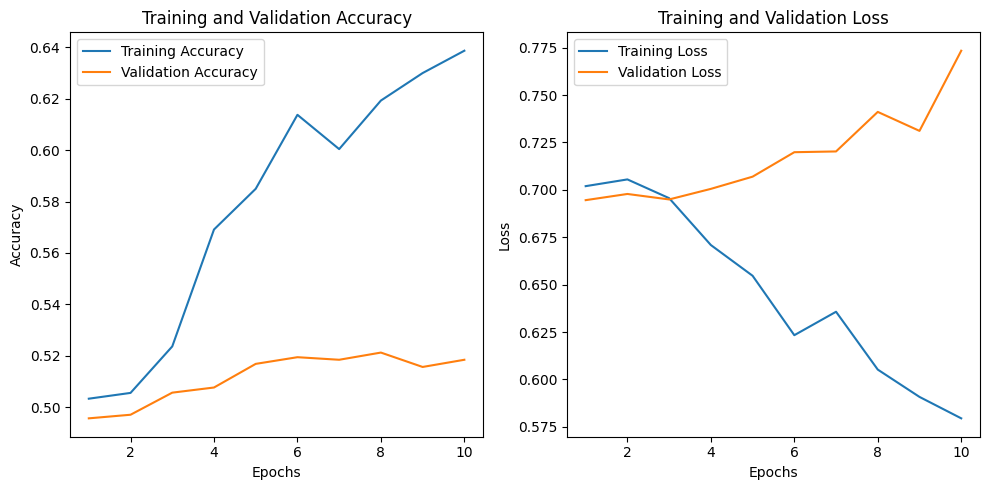

In [ ]:
import matplotlib.pyplot as plt

# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Analysons les resultats obtenus avec cette architecture :

La précision sur le jeu d'apprentissage augmente de façon constante, atteignant les 64,63%. Cependant, la précision de validation stagne autour des 50%, ce qui signifie que la classification binaire est proche du hasard.

La différence de précision entre l'apprentissage et la validation indique un surapprentissage: le modèle s'adapte spécifiquement aux données d'apprentissage, et ne généralise pas sur les données non-vues. Le modèle n'apprend pas les représentations présentes dans l'ensemble de validation.

Ce constat se confirme avec les pertes. La perte d'apprentissage diminue constamment, indiquant que le modèle apprend bel et bien sur les données d'entrainement. Cependant la perte sur l'ensemble de validation ne fait qu'augmenter au fur et à mesure des epochs. cela confirme le surapprentissage.

Pour améliorer ce modèle, nous devons tenir compte d'une part des faibles performances et d'autre part de la présence du surapprentissage.

On décide alors de rajouter une couche simple RNN. Cette couche permet au modèle d'apprendre des représentations plus abstraites après la première couche, et donc d'affiner les représentations. Cela améliore la capacité du modèle à capturer des représentations riches. De plus, gagner en profondeur de modèle peut aider à mieux modéliser les données d'entrée. On peut donc esperer de meilleures performances avec ce changement.

Cependant, qui dit apprentissage de caractéristiques plus complexes, dit risque de surapprentissage. En effet, en complexifiant notre modèle, nous augmentons le nombre de paramètres : il pourrait encore plus s'adapter aux données d'apprentissage et donc perdre en capacité de généralisation sur les données de validation. Rappelons enfin que nous avions déjà un fort overfitting.

Pour prévenir ce phénomène, nous allons ajouter une couche de dropout entre nos deux couches SimpleRNN. Le Dropout aide à régulariser le modèle en désactivant de manière aléatoire des neurones pendant l'apprentissage. Cela empêche le modèle de devenir trop dépendant de certains neurones, et permet ici de régulariser la sortie de chaque couche RNN avant qu'elle ne soit transmise à la suivante. Nous allons aussi augmenter le dropout à 30% après chacune de ces couches.

De plus, Nous allons rajouter une régularisation L2 qui pénalise les poids trop grands dans les couches denses, ce qui réduit le surapprentissage.

Pour finir, notons la structure des deux couches SimpleRNN :

La première couche SimpleRNN est définie avec *return_sequences=True*, ce qui signifie qu'elle produit une sortie pour chaque pas temporel de la séquence. Cela permet à la deuxième couche SimpleRNN de recevoir une séquence complète en entrée.

La deuxième couche SimpleRNN est définie avec *return_sequences=False*, ce qui signifie qu'elle ne retourne que l'état caché final.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des séquences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # Facteur de régularisation L2

# Définition du modèle avec une couche SimpleRNN supplémentaire
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Première couche RNN
    Dropout(dropout_rate),  # Dropout après la première couche
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Deuxième couche RNN
    Dropout(dropout_rate),  # Dropout après la deuxième couche
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche finale avec régularisation L2
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (1, 200, 64)                │          10,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 200, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (1, 32)                     │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,697 (3.87 MB)

 Trainable params: 1,013,697 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.5078 - loss: 1.5347 - val_accuracy: 0.5016 - val_loss: 0.8323
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5031 - loss: 0.7857 - val_accuracy: 0.5090 - val_loss: 0.7140
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4980 - loss: 0.7172 - val_accuracy: 0.4970 - val_loss: 0.7011
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4977 - loss: 0.7009 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5027 - loss: 0.6958 - val_accuracy: 0.5030 - val_loss: 0.6941
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4974 - loss: 0.6946 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4969 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4951 - loss: 0.6935 - 

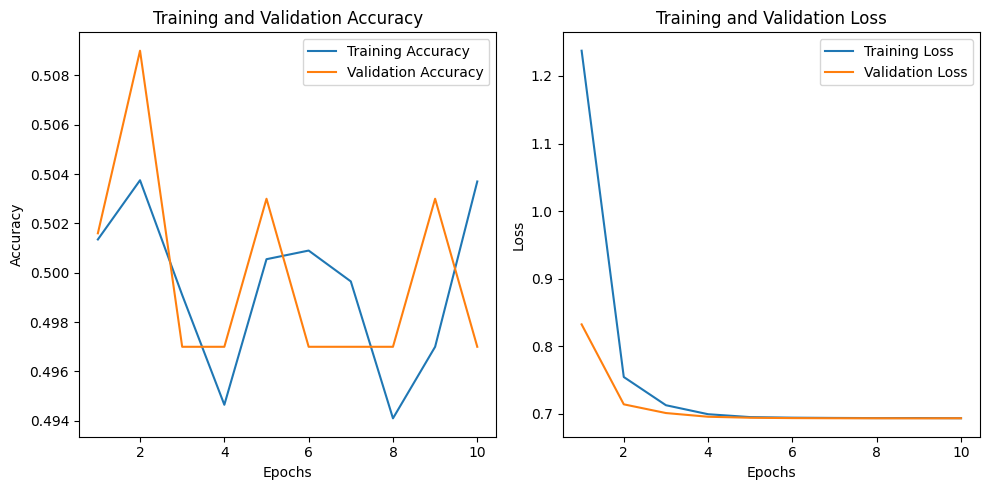

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les précisions sur l'apprentissage et la précision ne présentent plus de divergence importante. Le constat est le même concernant les pertes. Ces dernières diminue cette fois jusqu'à atteindre un plateau autour des 70%. Ces observations indiquent que le surapprentissage a disparu : Le modèle ne cherche plus à "surmémoriser" les données d'entraînement, ce qui est positif.
Cependant, le modèle stagne à une précision de 50%, que ce soit pour l'apprentissage comme la validation. En fait, le modèle n'apprend pas : il reste bloqué à une performance aléatoire, ce qui suggère qu'il n'est pas capable d'extraire des informations utiles des séquences.

Finalement, régulariser notre modèle avec la régularisation L2 et l'augmentation significative du dropout empêche le modèle de mémoriser les données exactes. La pénalisation des poids trop excessive limite aussi la complexité du modèle et donc sa capacité à extraire des informations utiles des séquences. Cependant, cela a aussi permis de prévenir le surapprentissage.

Il est aussi important de noter que les temps de calculs ont plus que doublé à chaque epochs en augmentant la complexité de notre modèle.

On décide d'essayer d’augmenter la capacité du modèle en ajoutant une troisième couche SimpleRNN. Cela peut permettre au réseau d'apprendre des caractéristiques plus complexes des données, en ajoutant davantage de profondeur. En gardant à l'esprit que les régularisations apportées à l'étape précedentes ont porté leur fruit, nous allons appliquer la même démarche, en ajoutant une couche de dropout entre chaque couche SimpleRNN, et en maintenant la régularisation L2 sur chacune de ces dernières.

Chaque couche RNN apprend des caractéristiques à un niveau d'abstraction différent. Une troisième couche peut aider à extraire des relations plus complexes. La première apprend les caractéristiques générales, la seconde capture des relations plus abstraites dans les séquences, et la troisième couche combine ces motifs pour construire des relations globales.

Cependant, on peut s'attendre à une augmentation conséquente du temps de calcul.


La première couche SimpleRNN est définie avec *return_sequences=True*, tout comme la seconde, ce qui signifie qu'elles produisent une sortie pour chaque pas temporel de la séquence. Cela permet à la dernière couche SimpleRNN de recevoir une séquence complète en entrée.

La dernière couche SimpleRNN est définie avec *return_sequences=False*, ce qui signifie qu'elle ne retourne que l'état caché final.

On notera aussi ici que chaque couche RNN augmente la mémoire utilisée, car elle doit gérer des états temporels à chaque étape. Utiliser un batch size plus petit peut aider à limiter l'utilisation mémoire. On passe donc de 64 à 32.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des séquences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # Régularisation L2

# Modèle avec 3 couches SimpleRNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Première couche RNN
    Dropout(dropout_rate),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Deuxième couche RNN
    Dropout(dropout_rate),
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Troisième couche RNN
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche de sortie
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=32  # Utiliser un batch plus petit pour éviter les erreurs mémoire
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (1, 200, 128)               │          29,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 200, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (1, 200, 64)                │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 200, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (1, 32)                     │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,801 (3.99 MB)

 Trainable params: 1,044,801 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 0.4907 - loss: 1.9050 - val_accuracy: 0.4970 - val_loss: 0.8023
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.4983 - loss: 0.7716 - val_accuracy: 0.5028 - val_loss: 0.7106
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4968 - loss: 0.7076 - val_accuracy: 0.5030 - val_loss: 0.6989
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4978 - loss: 0.6983 - val_accuracy: 0.4970 - val_loss: 0.6955
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.5026 - loss: 0.6949 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.4934 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6943
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.5053 - loss: 0.6937 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.5026 - loss: 0.6938 - 

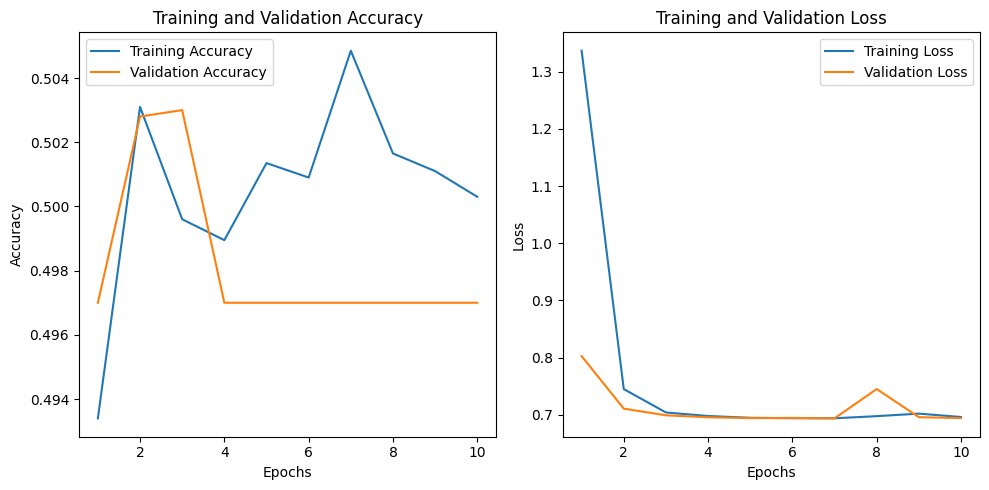

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "rnn_final.h5"  # Renommer le fichier
mod.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous rnn_final.h5


In [ ]:
from google.colab import files
files.download('rnn_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

La première observation que nous pouvons faire est que, malgré la complexification de notre modèle, nous arrivons à prévenir le surapprentissage avec une régularisation adaptée.

Cependant, l'ajout d'une troisième couche et donc l'augmentation de la profondeur du modèle ne semble pas être efficace. Les précisions stagnent autour des 50%. Le modèle est bloqué à un niveau aléatoire, et n'apprend toujours rien, et échouent à catpurer les relationsloin dans le temps, même en augmentant la profondeur du réseau.

Enfin, les temps de calculs ont bel et bien augmenté comme on pouvait s'y attendre suite à la compexification du modèle.






En fait, les RNN simples calculent des gradients qui diminuent exponentiellement avec le nombre d'étapes temporelles (ici max_length=200) à travers le BPTT. Cela empêche les couches profondes d'apprendre efficacement, car les gradients sont trop faibles pour mettre à jour les poids. En somme, les couches SimpleRNN sont simplement peu performantes pour des séquences longues.

Ce phénomène est connu sous le nom de *Vanishing Gradient*.

Le problème principal vient finalement du RNN lui-même et de sa structure. Avec max_length=200, le modèle doit apprendre des relations qui se trouvent loin dans le temps, mais échoue à capturer ces relations, et ce malgrè l'ajout de profondeur.


Afin, d'éviter le *Vanishing Gradient* et capturer des relations à long terme dans les séquences, d'autres arhitectures adaptées existent, comme les LSTM et les GRU, que nous allons abordé dans la partie suivante.

##LSTM

Comme indiqué et observé dans la partie précédente, les RNN souffrent du problème de *Vanishing Gradient* lors de l'entrainement sur des séquences longues à travers le BPTT.

Les Long Short-Term Memory, ou **LSTM**, sont une variante des RNN permettant une meilleure gestion de la mémoire à long terme, conçu pour résoudre le problème de *Vanishing Gradient*.

Dans les LSTM sont introduits le principe de *cellules* qui gèrent la mémoire à long terme en stockant des informations importantes sur de longues périodes, et les *gates* qui contrôle le flux d'information à travers le réseau.

Là où les RNN simple utilisent seulement des états latents, c'est à dire une mémoire à court termes qui contient l'information immédiate à transmettre à la prochaine étape, les LSTM utilisent aussi des cellules, c'est à dire une mémoire à long terme, qui stocke des informations importantes sur de longues périodes. Notons $C_t$ l'état de cellule à l'instant $t$, et $h_t$ l'état latent, ou caché, à l'instant $t$ pour la suite.

Il existe 3 portes qui ont des fonctions bien précises :

*   Les **Forget Gates** : Elles contrôlent quelles informations anciennes seront oubliées, c'est à dire quelles informations conservées dans l'état $C_{t-1}$ seront oubliées.
Soient : $f_t$ le vecteur de la **Forget Gate**, $W_f$ et $b_f$ respectivement les poids et biais de la **Forget Gate**, $x_t$ l'entrée à l'instant $t$, et enfin $h_{t-1}$ l'état latent à l'instant ${t-1}$. Alors :

$$
\begin{aligned}
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
\end{aligned}
$$

*   Les **Input Gates** : Elles contrôlent la quantité de nouvelle information ajoutée à la mémoire, c'est à dire quelles nouvelles informations de l'entrée actuelle $x_t$ seront ajoutées à l'état de cellule. Soient : $i_t$ le vecteur de la **Input Gate**, $W_i$ et $b_i$ respectivement les poids et biais de la **Input Gate**, $x_t$ l'entrée à l'instant $t$, et enfin $h_{t-1}$ l'état latent à l'instant ${t-1}$. Alors :

$$
\begin{aligned}
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
\end{aligned}
$$


*   Les **Output Gates** : Elles contrôlent quelles informations seront utilisées pour la sortie à l'instant $t$, c'est à dire quelles informations de la cellule $C_t$ seront envoyées à l'état latent $h_t$.
Soient $o_t$ le vecteur de la **Output Gate**, $W_o$ et $b_o$ respectivement les poids et biais de la **Output Gate**, $x_t$ l'entrée à l'instant $t$, et enfin $h_{t-1}$ l'état latent à l'instant ${t-1}$. Alors :

$$
\begin{aligned}
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
\end{aligned}
$$





L'état de cellule $C_t$ est défini par la combinaison des informations que l'on conserve et des nouvelles informations ajoutées. Soient $W_C$ et $b_C$ respectivement les poids et biais de l'état de $C_t$, $x_t$ l'entrée à l'instant $t$, et enfin $h_{t-1}$ l'état latent à l'instant ${t-1}$. Si l'on note $\tilde{C}$ le candidat à l'état de cellule tel que :

$$
\begin{aligned}
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
\end{aligned}
$$

Alors on met à jour les informations dans la cellule $C_t$ avec :

$$
\begin{aligned}
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
\end{aligned}
$$

Enfin, on met à jour l'état latent $h_t$ avec :

$$
\begin{aligned}
h_t = o_t \odot \tanh(C_t)
\end{aligned}
$$

Pour définir notre architecture LSTM, nous commencons par une couche d'embeddings entrainable, comme ce qui a pu être fait dans la partie RNN plus haut.

On ajoute une couche LSTM pour capter les dépendances temporelles de nos séquences. On décide d'utiliser 128 unités de manière arbitraire, assurant une profondeur jugée suffisante pour optenir des représentations pertinentes sans rendre le modèle trop complexe. Enfin, on définit le paramètre *retrun_sequences=False* car nous sommes dans le cas d'un *Many-To-One* comme expliqué précedemment.

On ajoute une couche de dropout entre la couche LSTM et la couche dense pour régulariser et prévenir le surapprentissage.

La classification binaire est assurée par la dernière couche dense à 1 unité et l'activation sigmoid. Comme précedemment, la fonction perte est une Cross-Entropy binaire, et on utilise par défaut l'optimiseur Adam.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Paramètres

embedding_dim=100
dropout_rate = 0.5   # Taux de Dropout pour régularisation

# Construction du modèle
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),  # Une seule couche LSTM
    Dropout(dropout_rate),  # Régularisation pour éviter l'overfitting
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5022 - loss: 0.6942 - val_accuracy: 0.5224 - val_loss: 0.6913
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5514 - loss: 0.6886 - val_accuracy: 0.5280 - val_loss: 0.6877
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5990 - loss: 0.6340 - val_accuracy: 0.7918 - val_loss: 0.5583
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7034 - loss: 0.5468 - val_accuracy: 0.5006 - val_loss: 0.7950
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6192 - loss: 0.6020 - val_accuracy: 0.5234 - val_loss: 0.7285
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6602 - loss: 0.5355 - val_accuracy: 0.7344 - val_loss: 0.6232
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8524 - loss: 0.3738 - val_accuracy: 0.7994 - val_loss: 0.5508
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9193 - loss: 0.2214 - val_accu

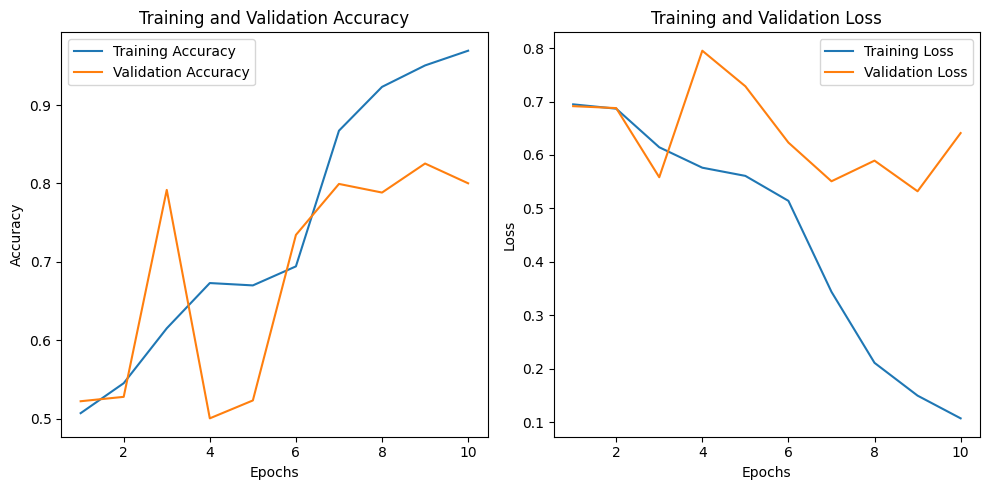

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Notons qu'avec une seule couche LSTM, l'empreinte mémoire est déjà plus élevée qu'avec notre RNN final à 3 couches SimpleRNN. Les temps de calculs sont cependant bien plus faible (Ici 14 secondes en moyenne par epochs contre 70 secondes de moyenne pour le RNN)

Les résultats montrent une amélioration claire avec l'utilisation des LSTM par rapport aux SimpleRNN. Nous passons de 50% à 97,25% de précision sur les données d'apprentissage. Le modèle parvient maintenant à apprendre les relations pertinentes dans les données d'apprentissage. La précision de validation quant à elle atteint les 80,02%, meilleur résultat jusqu'à présent.

La perte d'apprentissage diminue jusqu'à 10%, tandis que la perte de validation fluctue autour des 60%, et n'est pas stable. Elle reste cependant bien inférieure à celle des RNN.

En somme, notre LSTM résout bien le problème de *Vanishing Gradient*. Notre modèle apprend donc efficacement sur les données d'apprentissage.

Les divergences observées entre la précision d'apprentissage et de validation, mais aussi entre la perte d'apprentissage et de validation, traduise un surapprentissage de notre modèle, nuisant aux capacités de généralisation.  

On décide dans un premier temps d'ajouter 2 couches denses afin de traiter la sortie LSTM pour capturer des relations non-linéaires dans les séquences et affiner les caractéristiques extraites par la couche LSTM. Cela permet de comprimer et combiner ces caractéristiques pour améliorer la capacité de décision du modèle, et ainsi améliorer la précision de validation. On n'ajoute pas de nouvelle couche LSTM car le modèle surapprend déjà. Augmenter la complexité du modèle ne ferait qu'augmenter ce constat.

Enfin, pour gérer l'overfitting, on ajoute une couche de dropout entre les deux couches Dense, ainsi qu'une régularisation L2 pour limiter les poids excessifs. On diminue aussi le learning rate afin de stabiliser la convergence et rendre les pertes plus stables au fil des épochs.

Pour finir, on ajoute un Early Stopping, permettant d'arrêter l'entrainement lorsque la perte de validation n'évolue plus.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Paramètres
dropout_rate = 0.5  # Taux de dropout
l2_reg = 0.01       # Régularisation L2
learning_rate = 0.0005  # Learning rate ajusté

# Modèle avec couches Dense, Dropout et régularisation L2
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(dropout_rate),  # Dropout après LSTM
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Première couche Dense
    Dropout(dropout_rate),  # Dropout pour régulariser
    Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),  # Deuxième couche Dense
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])


# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate optimisé
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

# Entraînement avec EarlyStopping pour surveiller l'overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Autoriser plus d'époques avec EarlyStopping
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5020 - loss: 1.4940 - val_accuracy: 0.4970 - val_loss: 0.7905
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5016 - loss: 0.7492 - val_accuracy: 0.4970 - val_loss: 0.6982
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4884 - loss: 0.6960 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4965 - loss: 0.6933 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accu

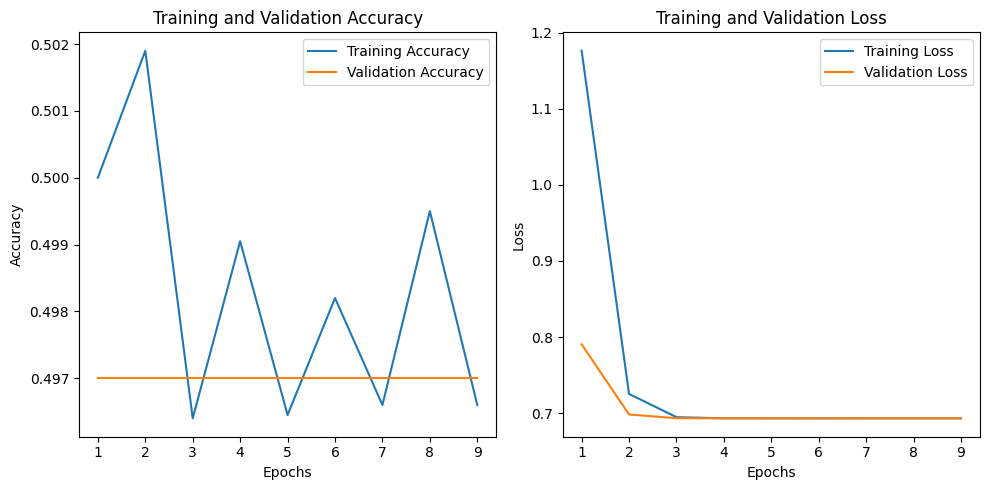

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Avec cette architecture, on obtient une précision qui stagne autour des 50%. Les différentes pertes sont quant à elles bloquées autour de 69%. Les prédictions sont donc aléatoires.

Ici, affiner les représentations par des couches denses n'a rien amélioré. Le surapprentissage a été supprimé au prix de performances médiocres : le modèle n'apprend pas.

Les améliorations au niveau de la perte de validation ne sont pas notables.

Cette stagnation des performances est sûrement dûe à un manque de représentations de qualité en entrée du modèle. En effet, les embeddings actuels sont appris de zéro. Cela est inéfficace et demande beaucoup de données pour obtenir des représentations pertinentes. Une solution intéressante serait ici d'utiliser des embeddings pré-entrainés qui fournissent des représentations riches. Cela permettrait au modèle de mieux généraliser et d'apprendre plus rapidement.

### Utilisation d'Embeddings pré-entrainés

L’utilisation d’embeddings pré-entraînés, comme **GloVe**, peut être très bénéfique ici. **Global Vectors for Word Representation** est un modèle pré-entraîné qui capture les relations sémantiques et transforme les mots en vecteurs numériques. Les embeddings GloVe ont été appris à partir de vastes corpus comme Wikipédia, et garantissent une représentation riche et générale du language.

GloVe se base sur les cooccurrences globales des mots dans un corpus : il détecte combien de fois deux mots apparaissent ensemble dans un même contexte donné. Il capture à la fois les relations locales et globales entre les mots.

Utiliser des embeddings pré entrainés permettra d'exploiter une compréhension initiales des relations entre les mots, sans réapprendre de zéro. Ils permettent généralement d'obtenir de meilleurs résultats sur les données de validation, tout particulièrement sur des datasets de taille modérée comme le nôtre.


Nous décidons ici d'utiliser des embeddings pré entrainés fixes, c'est à dire non entrainables (paramètre *trainable=False*). Cela permet de réduire le risque de surapprentissage. Geler les poids empêche le modèle de modifier les embeddings créés lors de l'entrainement de GloVe.

In [ ]:
import os
import urllib.request
import zipfile

# Créer un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Télécharger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Téléchargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("Téléchargement terminé.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction terminée. Les fichiers sont disponibles dans :", glove_dir)


Téléchargement des embeddings GloVe...
Téléchargement terminé.
Extraction des fichiers GloVe...
Extraction terminée. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings chargés : {len(embedding_index)}")

# Créer la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succès.")


Nombre d'embeddings chargés : 400000
Matrice d'embeddings GloVe construite avec succès.


In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fusionner toutes les critiques en un seul corpus
all_reviews = " ".join(train_texts_cleaned + test_texts_cleaned)
words = all_reviews.split()

# Filtrer les mots pour exclure les stopwords et les mots courts
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 2]

# Compter les mots
word_counts = Counter(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Vérifier la couverture du vocabulaire IMDb dans GloVe
glove_vocab = set(embedding_index.keys())  # Vocabulaire de GloVe
imdb_vocab = set(word_counts.keys())      # Vocabulaire du dataset IMDb

# Proportion de mots IMDb présents dans GloVe
coverage = len(imdb_vocab & glove_vocab) / len(imdb_vocab) * 100
print(f"Proportion du vocabulaire IMDb couvert par GloVe : {coverage:.2f}%")

Proportion du vocabulaire IMDb couvert par GloVe : 33.70%


On voit que seulement un tiers de notre vocabulaire est couvert par GloVe. Cela aura surement un impact sur les prédictions.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Définir le modèle avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),  # Fixe les embeddings pour éviter d'apprendre de zéro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # Régularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour éviter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense intermédiaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé
model.summary()

# Entraîner le modèle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 127,617 (498.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5058 - loss: 1.5145 - val_accuracy: 0.5008 - val_loss: 0.8187
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5003 - loss: 0.7699 - val_accuracy: 0.5060 - val_loss: 0.7029
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5140 - loss: 0.6994 - val_accuracy: 0.4982 - val_loss: 0.6941
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5209 - loss: 0.6935 - val_accuracy: 0.5114 - val_loss: 0.6983
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5192 - loss: 0.6927 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5012 - loss: 0.6926 - val_accuracy: 0.5072 - val_loss: 0.6928
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5149 - loss: 0.6924 - val_accuracy: 0.5076 - val_loss: 0.6927
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5118 - loss: 0.6923 - val_accu

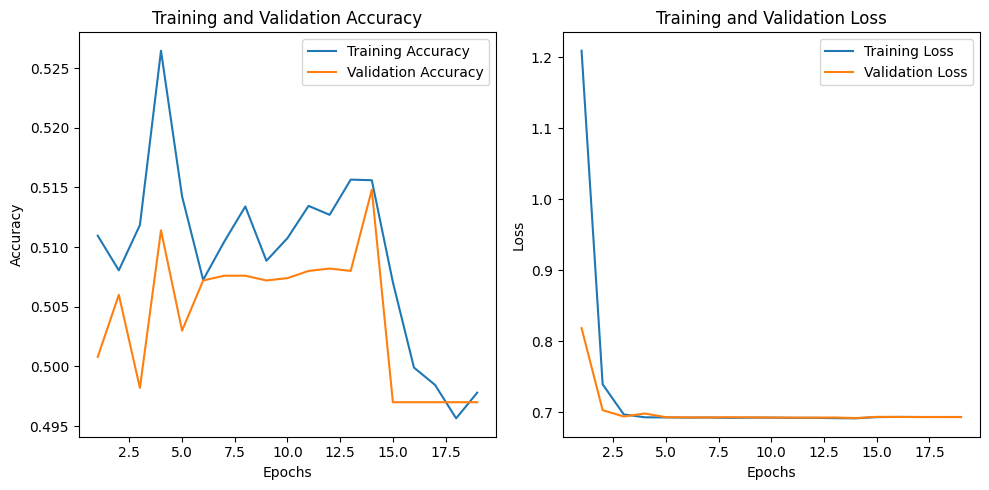

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les résultats montrent encore que la précision stagne autour des 50%, tout comme la perte qui n'évolue plus à partir d'environ 70%.






En fixant les poids des embeddings GloVe *(trainable=False)*, le modèle utilise les représentations telles quelles, sans s'adapter à notre jeu de données. GloVe ne couvre que 33,70% du vocabulaire IMdB. Cela peut expliquer les faibles performances du modèle.


Nous décidons donc de rendre les embeddings GloVe entraînable *(trainable=True)*. Le modèle pourra ajuster ces embeddings aux relations sémantiques spécifiques à notre dataset.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Définir le modèle avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Fixe les embeddings pour éviter d'apprendre de zéro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # Régularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour éviter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense intermédiaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé
model.summary()

# Entraîner le modèle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5068 - loss: 1.5070 - val_accuracy: 0.5456 - val_loss: 0.8156
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5173 - loss: 0.7681 - val_accuracy: 0.4970 - val_loss: 0.7035
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5061 - loss: 0.6992 - val_accuracy: 0.5118 - val_loss: 0.6937
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5129 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6938
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5025 - loss: 0.6935 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5045 - loss: 0.6932 - val_acc

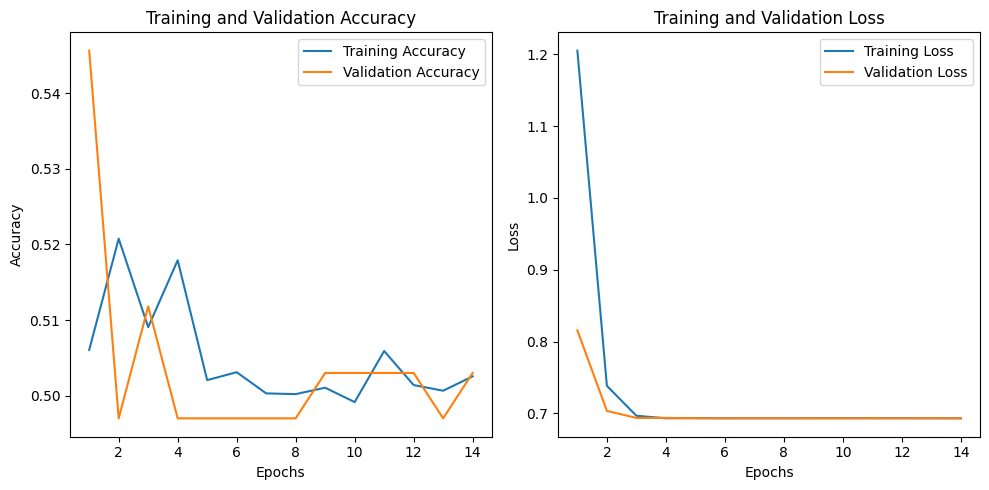

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Même après avoir rendu les embeddings GloVe entraînables, les performances n'améliorent pas. Le modèle sous apprend. Si la couche LSTM ne permet pas d'apprendre les informations pertinentes, ajouter des couches dense ne sert à rien et apporte de la complexité inutile.

Une explication possible aux faibles performances pourrait être une égularisation excessive. Avec des dropout de 50% et des régularisations L2, on limite les capacités d'apprentissage du modèle.


Puisque les meilleures performances jusqu'à présent ont été obtenues avec une seule couche LSTM sans couche Dense, nous allons revenir à une architecture plus simple, sans régularisation excessive.


Les embeddings GloVe apportent tout de même une base solide, nous allons donc les conserver entrainables.

Nous décidons ici de modérer le dropout en passant de 50% à 30%.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modèle simplifié
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe entraînables
    LSTM(128, return_sequences=False),  # Couche LSTM unique
    Dropout(0.3),  # Dropout modéré
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement avec EarlyStopping
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Maximum de 20 epochs
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5341 - loss: 0.6899 - val_accuracy: 0.5490 - val_loss: 0.6795
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5682 - loss: 0.6756 - val_accuracy: 0.5120 - val_loss: 0.6738
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5373 - loss: 0.6927 - val_accuracy: 0.5336 - val_loss: 0.6899
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5287 - loss: 0.6919 - val_accuracy: 0.5382 - val_loss: 0.6866
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5630 - loss: 0.6784 - val_accuracy: 0.6388 - val_loss: 0.6347
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6109 - loss: 0.6652 - val_accuracy: 0.7608 - val_loss: 0.5942
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7723 - loss: 0.5336 - val_accuracy: 0.8286 - val_loss: 0.3937
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8641 - loss: 0.3388 - val_accu

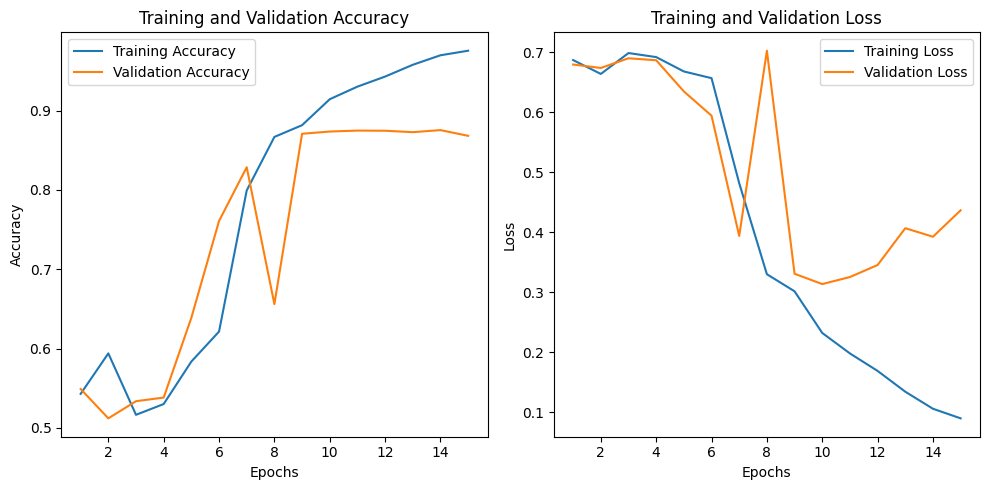

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les embeddings pré entrainés ajustables permettent au modèle d'adapter les représentations pour mieux correspondre au dataset IMDb.

Le dropout modéré nous a aussi permis de réguler le surapprentissage.

L’accuracy en validation atteint 86.82%, ce qui est une amélioration significative. La précision d'apprentissage quant à elle approche les 98% en fin d'entrainement.

L’entraînement s’est arrêté avant que l’overfitting devienne trop important grâce à l'early stopping, permettant au modèle de généraliser sur l’ensemble de validation.

La divergence entre la précision d'apprentissage et la précision de validation sur la fin indique un surapprentissage, confirmé par l'augmentation de la perte de validation sur la fin. Enfin, le fait que la précision de validation plafonne à environ 87,5% indique que le modèle pourrait mieux généraliser.

Plusieurs solutions s'offrent à nous pour gérer les différents problèmes rencontrés : nous allons augmenter le dropout pour renforcer la régularisation. Une régularisation L2 est intéressant sur la couche LSTM afin de gérer l'overfitting. Enfin, diminuer le learning rate nous permet de stabiliser l'entrainement sur les dernières epochs.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition du modèle avec les ajustements
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # Régularisation L2 sur LSTM
    Dropout(0.4),  # Dropout augmenté pour limiter l'overfitting
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0003),  # Learning rate réduit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour arrêter automatiquement l'entraînement en cas de stagnation
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,  # Données d'entraînement
    validation_data=(train_padded_val, train_labels_val),  # Données de validation
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # Callback pour EarlyStopping
    verbose=1
)

# Résumé du modèle pour vérification
model.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5131 - loss: 1.6875 - val_accuracy: 0.4986 - val_loss: 0.8770
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5101 - loss: 0.8399 - val_accuracy: 0.4972 - val_loss: 0.8232
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5334 - loss: 0.7735 - val_accuracy: 0.5820 - val_loss: 0.7324
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6485 - loss: 0.7123 - val_accuracy: 0.5440 - val_loss: 0.7476
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5711 - loss: 0.7337 - val_accuracy: 0.5518 - val_loss: 0.7434
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5470 - loss: 0.7379 - val_accuracy: 0.5596 - val_loss: 0.7237
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5559 - loss: 0.7284 - val_accuracy: 0.5602 - val_loss: 0.7253
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5621 - loss: 0.7142 - val_acc

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

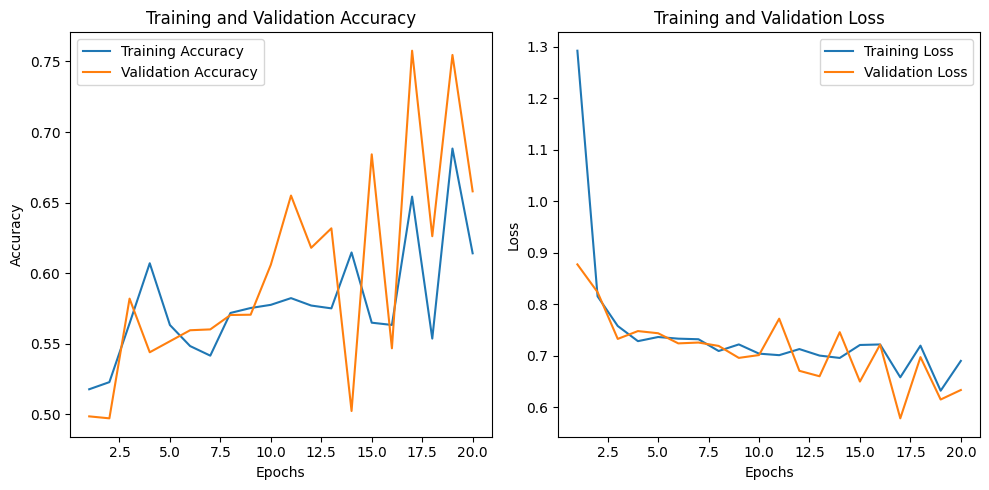

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les performances en précision fluctuent d’une époque à l’autre, passant de 65%, à 50%, puis 75%, puis 55%. Cette instabilité traduit un modèle sensible aux paramètres, encore sous optimisés.

La divergence entre la précision d'apprentissage et la précision de validation montre un overfitting partiel, bien qu'instable. Le modèle sur-apprend sans bien généraliser.


Il convient maintenant de réduire encore le learning rate pour stabiliser l'apprentissage. Le dropout est sûrement trop important à ce stade, réduisant la capacité d'apprentissage du modèle. On décide de revenir à 30%.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle ajusté
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # Régularisation L2
    Dropout(0.3),  # Dropout ajusté
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Compilation avec learning rate plus faible
model.compile(optimizer=Adam(learning_rate=0.0001),  # Learning rate réduit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping avec patience plus stricte
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping ajusté
    verbose=1
)

# Résumé du modèle pour vérification
model.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4994 - loss: 2.0647 - val_accuracy: 0.5348 - val_loss: 1.3697
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5326 - loss: 1.2385 - val_accuracy: 0.5642 - val_loss: 0.9503
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6350 - loss: 0.8864 - val_accuracy: 0.7316 - val_loss: 0.7383
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6976 - loss: 0.7393 - val_accuracy: 0.6924 - val_loss: 0.7024
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7249 - loss: 0.6803 - val_accuracy: 0.7766 - val_loss: 0.6112
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7266 - loss: 0.6553 - val_accuracy: 0.7728 - val_loss: 0.5903
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7839 - loss: 0.5850 - val_accuracy: 0.8010 - val_loss: 0.5373
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8072 - loss: 0.5269 - val_accu

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

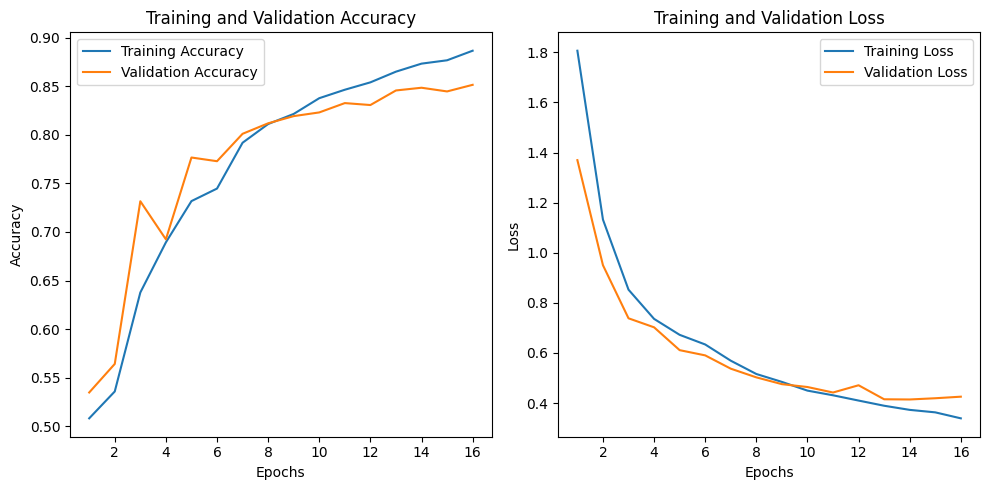

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Le modèle apprend correctement sur l’ensemble d’entraînement. La précision d'apprentissage (88.6%) et la précision de validation (85.1%) sont très proches, indiquant qu'on a prévenu l'overfitting.

Les performances sont stables, les pertes aussi, et bien meilleures que toutes les configurations précédentes.

Rendre les embeddings trainables a permis au modèle de s’adapter aux nuances spécifiques du dataset IMDb.

Une seule couche LSTM avec 128 unités semble suffire en termes de profondeur de modèle à capturer lse informations pertinentes des données. La suppression des couches Dense a permis de stabiliser l'apprentissage comme l'indiquent les courbes.

Enfin, un learning rate adapté a permis au modèle de converger lentement et efficacement, en particulier sur les dernières époques, rendant les courbes de perte stables au cours de l'apprentissage.

À partir de l’époque 14-15, la validation loss recommence légèrement à augmenter tandis que l’accuracy reste stable. Cela pourrait indiquer un début de surapprentissage léger, mais les performances globales restent très intéressantes.

Pour finir, la précision de validation atteint environ 85% mais semble plafonner. La capacité du modèle est limitée par la profondeur actuelle.

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_pasmal1.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Nous allons ajouter une seule couche Dense de petite taille à 32 unités pour affiner la décision finale. Cela permettra de stabiliser les performances tout en essayant de dépasser le plateau de validation de l'architecture précedente. Un dropout entre chaque couche est ajouté pour prévenir le surapprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle ajusté avec une couche Dense supplémentaire
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # LSTM avec régularisation L2
    Dropout(0.3),  # Dropout pour régularisation
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Nouvelle couche Dense
    Dropout(0.3),  # Dropout pour régularisation
    Dense(1, activation='sigmoid')  # Couche finale pour la classification
])

# Compilation avec un learning rate bas
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping ajusté
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5046 - loss: 2.5164 - val_accuracy: 0.5322 - val_loss: 1.7008
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5489 - loss: 1.5320 - val_accuracy: 0.6554 - val_loss: 1.1422
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6830 - loss: 1.0609 - val_accuracy: 0.7514 - val_loss: 0.8615
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7467 - loss: 0.8478 - val_accuracy: 0.7742 - val_loss: 0.7359
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7895 - loss: 0.7016 - val_accuracy: 0.8050 - val_loss: 0.6219
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8111 - loss: 0.6108 - val_accuracy: 0.8154 - val_loss: 0.5631
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8170 - loss: 0.5606 - val_accuracy: 0.8224 - val_loss: 0.5282
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8349 - loss: 0.5206 - val_accuracy: 0.838

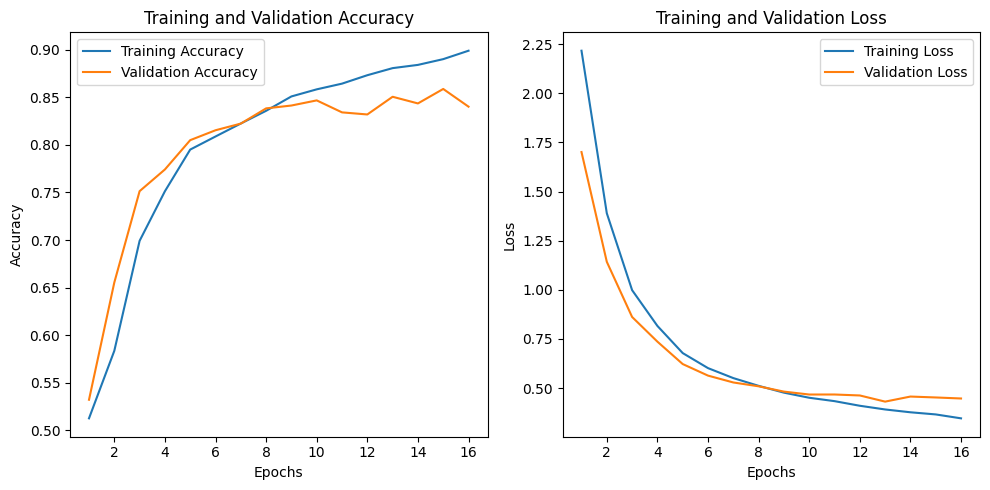

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

La petite couche Dense a permis de comprimer et combiner les informations extraites par la LSTM, améliorant légerement la précision d'apprentissage (88.63% avant pour 89.4% maintenant).  

Le Dropout à 0.3 et la régularisation L2 sur la LSTM ont permis de limiter l’overfitting tout en préservant les capacités d’apprentissage.



A l'époch 14, la perte de validation oscille autour de 0.45, présentant une légère augmentation.
Cela peut indiquer que le modèle commence à sur-apprendre.

L'idée ici est d'ajouter une deuxième couche LSTM en renvoyant les séquences à la seconde couche, comme ce qu'on a pu faire pour les RNN.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle avec deux couches LSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),  # Première couche LSTM
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),  # Seconde couche LSTM
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec un learning rate encore plus bas
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5024 - loss: 4.1743 - val_accuracy: 0.5338 - val_loss: 3.3000
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5205 - loss: 3.0697 - val_accuracy: 0.5984 - val_loss: 2.4434
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5299 - loss: 2.3242 - val_accuracy: 0.5198 - val_loss: 1.9397
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5192 - loss: 1.8358 - val_accuracy: 0.5376 - val_loss: 1.5597
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5611 - loss: 1.4811 - val_accuracy: 0.6746 - val_loss: 1.2392
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6835 - loss: 1.1898 - val_accuracy: 0.7124 - val_loss: 1.0433
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7091 - loss: 1.0310 - val_accuracy: 0.7242 - val_loss: 0.9262
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7663 - loss: 0.8708 - val_acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,506,309 (13.38 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,337,540 (8.92 MB)

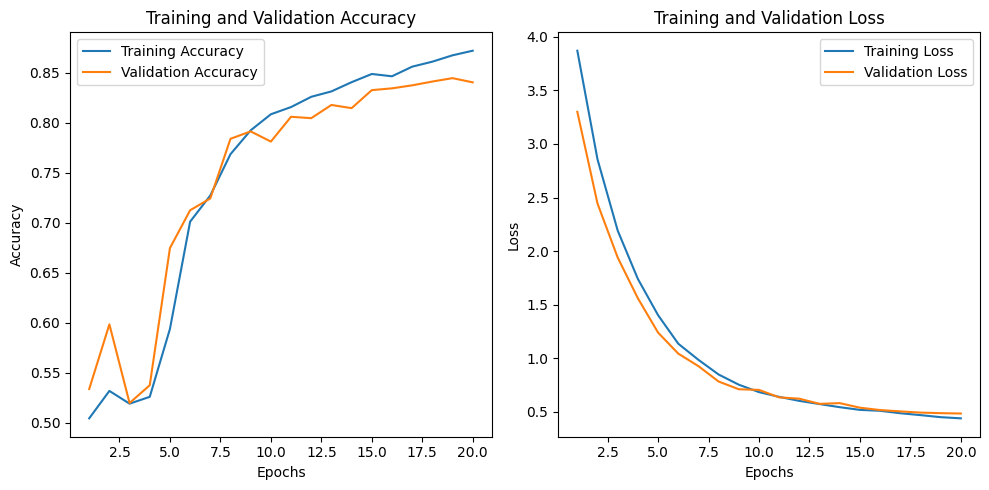

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_pasmal2.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

La divergence entre les pertes a été drastiquement réduite, traduisant une amélioration de la stabilité d'apprentissage. Quant aux signes de surapprentissage, ils ont été relativement réduits, mais sont toujours présents.

L’impact de la deuxième couche LSTM reste modéré. On peut tout de même indiquer que l'écart entre la précision d'apprentissage et la précision de validation a été réduit par rapport à l'architecture précedente, indiquant une meilleure généralisation. L'ajout de complexité a donc naturellement régularisé l'apprentissage. Cependant, cette couche n’améliore pas significativement la précision de validation. Cela suggère que le modèle avait déjà capturé la plupart des informations nécessaires avec une seule couche LSTM.

Avec une couche LSTM supplémentaire, le temps de calcul est suppérieur de 2 secondes en moyenne par epochs. Enfin, le nombre de paramètres augmente, passant de 3,352,133 à 3,506,309.

Le modèle à une seule couche LSTM et celui à 2 couches LSTM ont tous les deux la même précision de validation de 84,02%. Cependant, le second apporte une meilleure stabilité lors de l'apprentissage. De plus, l'écart entre la précision d'apprentissage et la précision de validation a été réduit, ce qui indique que ce second modèle a une meilleure généralisation.

On se propose maintenant de garder cette architecture en essayant cette fois d'optimiser les hyper paramètres. Pour ce faire, nous allons utiliser la bibliothèque Optuna. A l'instar du Grid Search, elle permet une optimisation automatique des hyperparamètres en testant différentes configurations possibles. La différence est qu'Optuna utilise une approche basée sur la recherche bayésienne.

Optuna permet de définir une fonction objectif qui retourne la performance du modèle sur un ensemble de validation. Il choisit ensuite intelligemment les hyperparamètres pour trouver le meilleur modèle, en essayant d'optimiser la précision de validation.  



Les hyperparamètres que l'on optimise ici sont :


*   Le learning rate
*   Le taux de dropout
*   Les unités de chacune des couches LSTM
*   Les unités de la couche Dense



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Taille première LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Taille seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Taille couche Dense

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 16:02:31,016] A new study created in memory with name: no-name-161812df-5889-4f69-bc85-147a6bdc4500
<ipython-input-29-57deda5af55f>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-29-57deda5af55f>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 16:04:23,191] Trial 0 finished with value: 0.8113999962806702 and parameters: {'

Meilleurs hyperparamètres : {'learning_rate': 0.0009698921196854575, 'dropout_rate': 0.3202765836299873, 'lstm_units_1': 224, 'lstm_units_2': 64, 'dense_units': 48}
Meilleure accuracy de validation : 0.883400022983551


Les meilleurs hyperparamètres suivants après 30 essais :

*  Learning rate : 0.000969 (proche de 1e-3)
*  Dropout : 0.32
*  LSTM units 1 : 224
*  LSTM units 2 : 64
*  Dense units : 48
*  Meilleure précision de validation : 88.3%


L’augmentation de la taille de la première couche LSTM a permis au modèle de capturer davantage de dépendances complexes dans les séquences.
Un Dropout ajusté à 0.32 a stabilisé l’apprentissage, évitant un surapprentissage excessif.
Le learning rate optimisé est plus élevé qu'avant (on passe de 0.0001 à 0.000969). Cela a accéléré la convergence tout en restant stable grâce au Dropout et à la régularisation L2. La seconde LSTM à 64 unités et la Dense à 48 unités ont permis de compresser les informations efficacement.

Le modèle a gagné en précision en validation (88.3%).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Création du modèle avec les meilleurs paramètres
final_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu'),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec le learning rate optimisé
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = final_model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5081 - loss: 0.6960 - val_accuracy: 0.5078 - val_loss: 0.6926
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4991 - loss: 0.6938 - val_accuracy: 0.5168 - val_loss: 0.6926
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5292 - loss: 0.6907 - val_accuracy: 0.5750 - val_loss: 0.6637
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7462 - loss: 0.5305 - val_accuracy: 0.8640 - val_loss: 0.3229
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8924 - loss: 0.2791 - val_accuracy: 0.8818 - val_loss: 0.2869
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9256 - loss: 0.2077 - val_accuracy: 0.8810 - val_loss: 0.3114
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9492 - loss: 0.1523 - val_accuracy: 0.8770 - val_loss: 0.3318
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9706 - loss: 0.1027 - val_accu

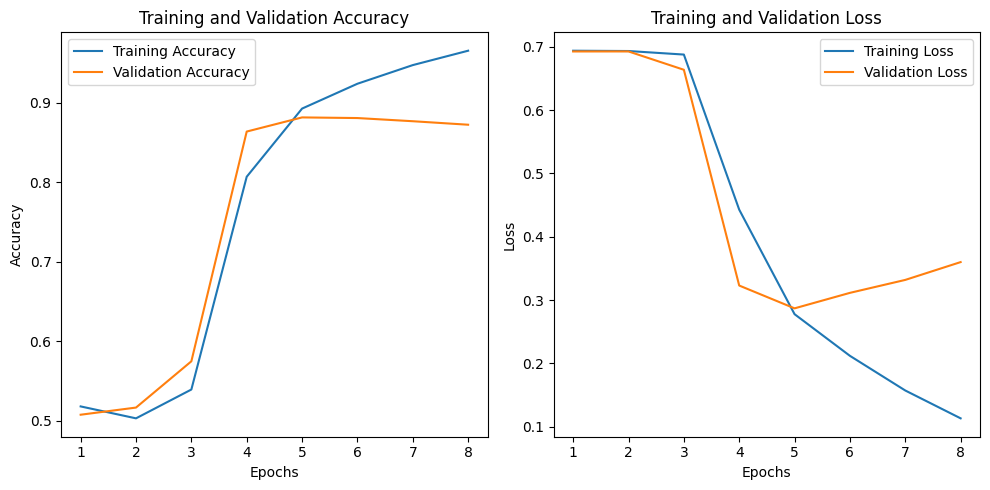

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV1.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Le modèle ajusté avec les hyperparamètres optimaux permet d'obtenir une précision de validation de 87,26%. La précision sur le jeu de données test est alors de 86,51%. Le faible écart entre les deux indique que le modèle a pu généraliser correctement, même si un léger overfitting persiste.

On décide finalement d'augmenter légèrement le dropout pour apporter un peu plus de régularisation, tout comme une régularisation L2 sur la couche dense.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Meilleurs hyperparamètres trouvés avec Optuna
best_params = {
    "learning_rate": 0.0009698921196854575,
    "dropout_rate": 0.35,  # Légère augmentation pour prévenir le surapprentissage
    "lstm_units_1": 224,
    "lstm_units_2": 64,
    "dense_units": 48
}

# Création du modèle amélioré
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"],
          activation='relu',
          kernel_regularizer=l2(0.001)),  # Régularisation L2 ajoutée
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compilation avec le learning rate optimisé
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5132 - loss: 0.7368 - val_accuracy: 0.5852 - val_loss: 0.6958 - learning_rate: 9.6989e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5417 - loss: 0.7034 - val_accuracy: 0.5400 - val_loss: 0.6987 - learning_rate: 9.6989e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5277 - loss: 0.6984 - val_accuracy: 0.5966 - val_loss: 0.6216 - learning_rate: 9.6989e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6060 - loss: 0.6630 - val_accuracy: 0.5700 - val_loss: 0.6934 - learning_rate: 9.6989e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5700 - loss: 0.6777 - val_accuracy: 0.8248 - val_loss: 0.4161 - learning_rate: 9.6989e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8434 - loss: 0.4052 - val_accuracy: 0.8492 - val_loss: 0.3669 - learning_rate: 9.6989e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc

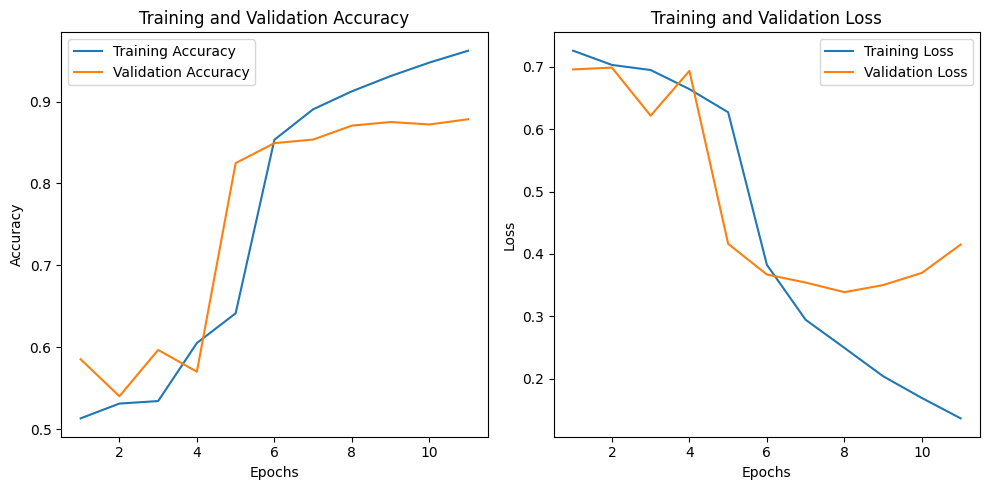

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV2.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

On n'obtient pas fondamentalement de meilleurs resultats, seule la divergence entre le la précision d'apprentissage et la précision de validation a été réduite. La précision de validation passe seulement de 87,26 à 87,84%. On décise tout de même de garder les régularisations apportées précedemment, tout en tentant de les optimiser via Optuna.

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-6, 1e-2)  # Regularization L2
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Première LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Couche Dense

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Exécution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 17:20:03,760] A new study created in memory with name: no-name-31e4da39-dca3-4187-8df2-d87251d37cfb
<ipython-input-42-c0ef995a8c06>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-42-c0ef995a8c06>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
<ipython-input-42-c0ef995a8c06>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_lambda = tr

Meilleurs hyperparamètres : {'learning_rate': 9.598549168523862e-05, 'dropout_rate': 0.4417831136139723, 'l2_lambda': 1.5189747596382268e-05, 'lstm_units_1': 96, 'lstm_units_2': 128, 'dense_units': 64}
Meilleure accuracy de validation : 0.873199999332428


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres trouvés avec Optuna
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "lstm_units_1": 96,
    "lstm_units_2": 128,
    "dense_units": 64
}


# Création du modèle
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"\nTest Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5121 - loss: 0.6986 - val_accuracy: 0.5518 - val_loss: 0.6886
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5807 - loss: 0.6785 - val_accuracy: 0.7032 - val_loss: 0.5905
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7354 - loss: 0.5773 - val_accuracy: 0.7582 - val_loss: 0.5475
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7740 - loss: 0.5216 - val_accuracy: 0.7880 - val_loss: 0.4880
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8056 - loss: 0.4625 - val_accuracy: 0.7978 - val_loss: 0.4591
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8243 - loss: 0.4226 - val_accuracy: 0.8120 - val_loss: 0.4349
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8415 - loss: 0.3902 - val_accuracy: 0.8042 - val_loss: 0.4345
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8507 - loss: 0.3691 - val_accu

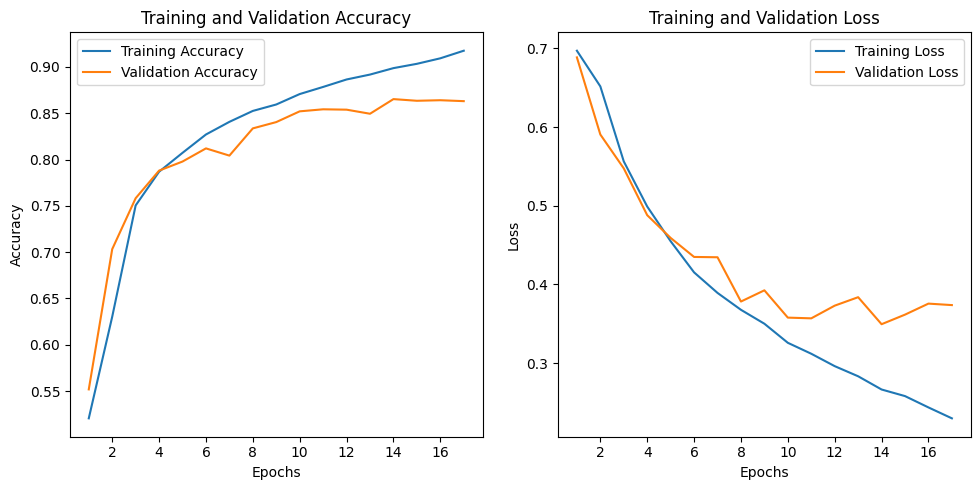

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV3.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV3.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Ce modèle atteint 85.48% de précision sur le test, très proche de la précision de validation, ce qui fait partie des meilleures performances obtenues jusqu'à présent. La perte de test de d'environ 36% face au 37% environ de la perte de validation indique que la régularisation L2 a apporté de la stabilité au modèle.

Le modèle atteint des performances acceptables à partir de l'epoch 5, ce qui est indique une convergence assez rapide.

Enfin, on notera des vitesses d'entrainement autour des 18 secondes par epochs.


C'est ici le modèle le plus équilibré et stable, qui généralise le mieux jusqu'à présent.


## GRU

Tout comme les LSTM, les **Gated Recurrent Unit** sont une variante des RNN permettant une meilleure gestion de la mémoire à long terme, conçu pour résoudre le problème de *Vanishing Gradient*. Utilsant seulement 2 portes (au lieu des 3 du LSTM), les **GRU** sont généralement plus rapides à entrainer et moins gourmands en ressources. Ils n'ont pas de mémoire cellulaire explicite comme ce que l'on peut observer dans les LSTM. Ce sont les états latents qui sont mis à jour à chaque pas de temps.

Les GRU utilisent deux portes principales :

*   Les **Update Gates** : Elle définissent combien d'informations passées sont conservées dans l'état présent.

*   Les **Reset Gates** : Elles contrôlent le nombre d'informations passées qui seront oubliées pour calculer le nouvel état candidat.


Les GRU sont généralement plus efficaces dans des contextes où les séquences sont modérement longues et où la complexité séquentielle est moindre.


Les LSTM peuvent parfois sur-apprendre ou mal converger de par leur complexité. C'est en fait ce que l'on a pu observé dans le modèle précedent. Les GRU étant plus légers et plus simple, on peut esperer éviter un surapprentissage inutile, des performances similaires, et ce tout en améliorant le temps d'entrainement et la consommation mémoire

Les GRU comme les LSTM sont adaptés aux séquences présentes dans notre jeu de données. Nous avons obtenu dans la partie précedente, à l'issue d'une optimisation intensive, un modèle LSTM performant. Il convient donc de reprendre cette même structure pour commencer à entrainer un GRU.

Nous allons remplacer les couches LSTM par des couches GRU dans notre modèle optimal. Nous conservons les hyper paramètres trouvés dans la partie précédent, à la difference près qu'on va changer le nombre de neurone pour avoir une architecture un peu plus "classique".


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Paramètres optimaux trouvés pour le LSTM (on les réutilise)
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "gru_units_1": 96,  # Taille de la première GRU (remplace LSTM)
    "gru_units_2": 128,  # Taille de la seconde GRU
    "dense_units": 64
}

# Création du modèle GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(128, return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    GRU(64, return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec learning rate optimal
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)






Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5019 - loss: 0.7014 - val_accuracy: 0.5230 - val_loss: 0.6961 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5090 - loss: 0.6992 - val_accuracy: 0.5234 - val_loss: 0.6936 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5221 - loss: 0.6948 - val_accuracy: 0.5442 - val_loss: 0.6888 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.5364 - loss: 0.6891 - val_accuracy: 0.5736 - val_loss: 0.6748 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5937 - loss: 0.6570 - val_accuracy: 0.6512 - val_loss: 0.6062 - learning_rate: 9.5985e-05
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7337 - loss: 0.5614 - val_accuracy: 0.8042 - val_loss: 0.4509 - learning_rate: 9.5985e-05
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8427 - loss: 0.3945
Test Accuracy : 0.8619
Test Loss : 0.3417


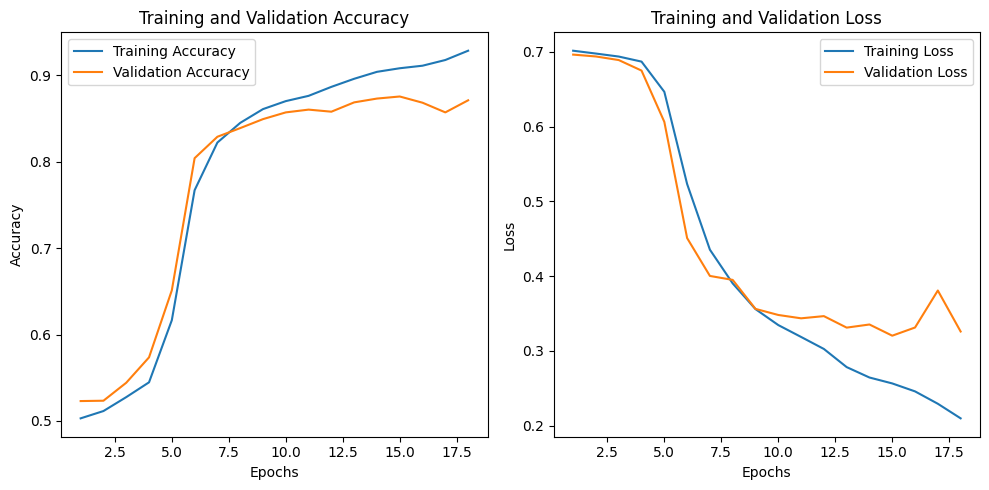

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "GRUV1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous GRUV1.h5


In [ ]:
from google.colab import files
files.download('GRUV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Notre modèle GRU obtient des résultats proches de ceux du LSTM précédent, qui atteignait 86.30% en validation et 85.48% en test, bien qu'un peu meilleur avec 87.12% en validation et 86.19% en précision de test.

La convergence commence ici à l'epoch 7, contre l'epoch 10 pour le LSTM, ce qui indique bien une convergence plus rapide avec le modèle GRU. Les temps d'entraînement observés sont relativement similaires à ceux obtenus avec le LSTM.


En somme, les deux architectures donnent des résultats compétitifs. Cependant, le GRU atteint une perte de validation plus faible que le LSTM (32.60 contre 37.37), ce qui peut indiquer qu'il converge mieux en termes de minimisation de l'erreur.



On peut observer un léger surapprentissage. Même si la précision de validation reste stable, il pourrait être intéressant de renforcer la régularisation dans notre cas.




Pour encore améliorer les résultats, nous allons aussi augmenter la profondeur du modèle en ajoutant des unités à la première couche GRU. Nous adaptons aussi le dropout et la régularisation L2 pour gérer le léger surapprentissage observé.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres optimisés pour GRU
gru_params = {
    "learning_rate": 9.5985e-05,
    "dropout_rate": 0.45,  # Augmenté pour améliorer la régularisation
    "l2_lambda": 3e-5,  # L2 légèrement renforcé
    "gru_units_1": 192,  # Augmenté pour capturer plus de dépendances
    "gru_units_2": 32,  # Inchangé
    "dense_units": 64
}

# Création du modèle GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(gru_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    GRU(gru_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(gru_params["dense_units"], activation='relu', kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec les meilleurs paramètres de learning rate
model.compile(optimizer=Adam(learning_rate=gru_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)




Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5029 - loss: 0.7061 - val_accuracy: 0.5282 - val_loss: 0.7008 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5116 - loss: 0.7030 - val_accuracy: 0.5342 - val_loss: 0.6986 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5192 - loss: 0.7002 - val_accuracy: 0.5412 - val_loss: 0.6935 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5467 - loss: 0.6924 - val_accuracy: 0.5858 - val_loss: 0.6640 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6477 - loss: 0.6418 - val_accuracy: 0.7862 - val_loss: 0.5055 - learning_rate: 9.5985e-05
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7513 - loss: 0.5632 - val_accuracy: 0.7546 - val_loss: 0.5487 - learning_rate: 9.5985e-05
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - 

Test Accuracy : 0.8584
Test Loss : 0.3415
Modèle sauvegardé sous gru_optimized_model.h5


In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8327 - loss: 0.4020
Test Accuracy : 0.8584
Test Loss : 0.3415


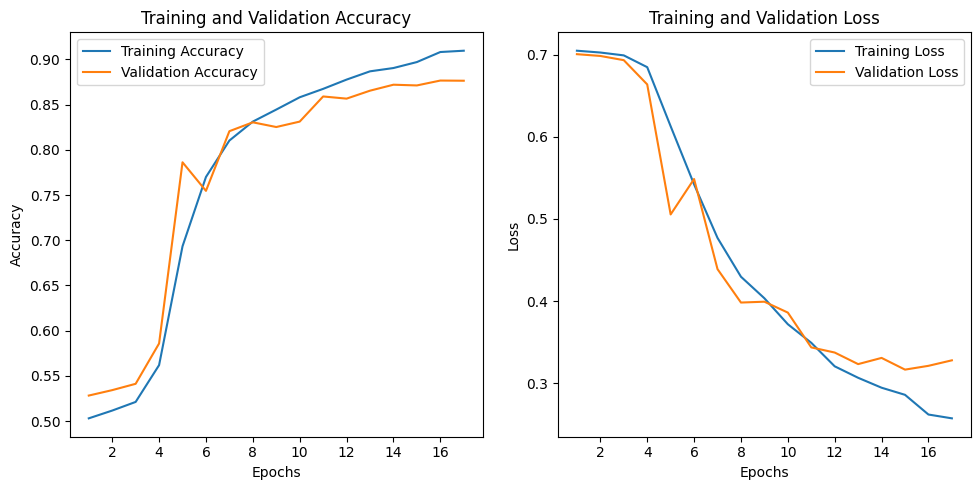

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle
model_path = "gruV2.h5"
model.save(model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous gruV2.h5


In [ ]:
from google.colab import files
files.download('gruV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cette structure nous permet de passer d'une précision de validation de 87.12% à 87.66%. La perte en validation est aussi plus faible ici.

On remarque ici que GRU actuel est légèrement plus rapide que le GRU précédent, avec des temps d'entraînement par epoch de 8 secondes en moyenne, ce qui se rapproche du LSTM optimisé précedemment.

Priorité recommandée : Hyperparamètres
Pourquoi ?
Problèmes de généralisation identifiés :

Le léger écart entre la précision de validation et celle de test (87.66% contre 85.84%) indique que la capacité actuelle du modèle est cohérente, mais que les différents paramètres peuvent encore être améliorés. C'est ce que nous allons faire en utilisant Optuna ci-après.


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition de la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)
    gru_units_1 = trial.suggest_int("gru_units_1", 64, 256, step=32)
    gru_units_2 = trial.suggest_int("gru_units_2", 16, 128, step=16)
    dense_units = trial.suggest_int("dense_units", 32, 128, step=16)

    # Construction du modèle GRU
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        GRU(gru_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        GRU(gru_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping pour éviter le surapprentissage
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0  # Pour ne pas polluer les logs
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Création et exécution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais ajustable

# Résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-18 10:03:33,088] A new study created in memory with name: no-name-96bde761-0794-4fdd-a822-b9301abf9eaa
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-18 10:06:49,596] Trial 0 finished with value: 0.8781999945640564 and parameters: {'learning_rate': 0.00023830415301578627, 'dropout_rate': 0.40127157312674655, 'l2_lambda': 7.777067103558865e-06, 'gru_units_1': 64, 'gru_units_2': 128, 'dense_units': 112}. Best is trial 0 with value: 0.8781999945640564.
[I 2024-12-18 10:08:50,233] Trial 1 finished with value: 0.8823999762535095 and parameters: {'learning_rate': 0.0005614085978383945, 'dropout_rate': 0.21056223469424937, 'l2_lambda': 8.814702901873964e-06, 'gru_units_1': 224, 'gru_units_2': 64, 'dense_units': 64}. Best is trial 1 with value: 0.8823999762535095.
[I 2024-12-18 10:12:11,972] Trial 2 finished with value: 0.6808000206947327 and parameters: {'

Meilleurs hyperparamètres : {'learning_rate': 0.00042492164788451327, 'dropout_rate': 0.3450843105981363, 'l2_lambda': 3.853917628612656e-06, 'gru_units_1': 160, 'gru_units_2': 32, 'dense_units': 64}
Meilleure accuracy de validation : 0.8871999979019165


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres optimisés pour GRU
optimized_params = {
    "learning_rate": 0.00042492164788451327,
    "dropout_rate": 0.3450843105981363,
    "l2_lambda": 3.853917628612656e-06,
    "gru_units_1": 160,
    "gru_units_2": 32,
    "dense_units": 64
}

# Création du modèle GRU final
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(optimized_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    GRU(optimized_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(optimized_params["dense_units"], activation='relu', kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale
])

# Compilation avec les meilleurs paramètres de learning rate
model.compile(optimizer=Adam(learning_rate=optimized_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5008 - loss: 0.6977 - val_accuracy: 0.5448 - val_loss: 0.6866 - learning_rate: 4.2492e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5371 - loss: 0.6859 - val_accuracy: 0.6112 - val_loss: 0.6276 - learning_rate: 4.2492e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6826 - loss: 0.6164 - val_accuracy: 0.5146 - val_loss: 0.6944 - learning_rate: 4.2492e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5102 - loss: 0.6959 - val_accuracy: 0.5946 - val_loss: 0.6626 - learning_rate: 4.2492e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6787 - loss: 0.5892 - val_accuracy: 0.8422 - val_loss: 0.3752 - learning_rate: 2.1246e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8540 - loss: 0.3654 - val_accuracy: 0.8640 - val_loss: 0.3294 - learning_rate: 2.1246e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step 

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8705 - loss: 0.3066
Test Accuracy : 0.8657
Test Loss : 0.3237


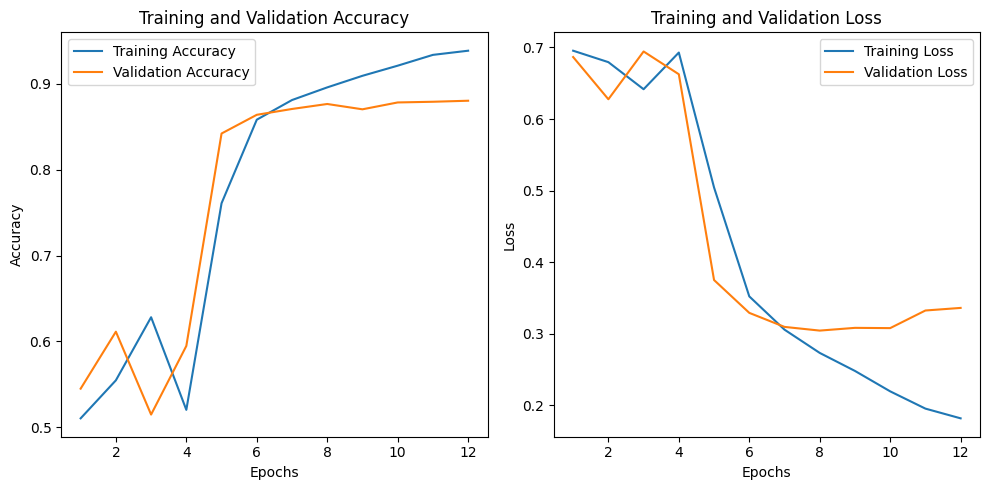

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle
model_path = "gru_optimal.h5"
model.save(model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous gru_optimal.h5


In [ ]:
from google.colab import files
files.download('gru_optimal.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Le modèle actuel affiche une précision de validation de 88.04% pour une précision sur l'échantillon test de 86.57%. La faible divergence entre ces deux résultats traduit une bonne généralisation du modèle.

La courbe de de perte de validation est plus stable que dans les essais précédents, indiquant une convergence plus robuste.

Les temps de calculs de chaque épochs d'environ 9 secondes sont raisonnables et correspondent aux configurations précédents.

On n'observe aucune divergence significative entre la perte de test et la perte de validation.

L'augmentation des unités dans la première couche GRU a ici aidé à capturer des dépendances complexes de notre jeu de données.
La réduction des unités dans la deuxième couche GRU permet quant à elle de limiter le surapprentissage.
Le Dropout à 0.345 et le L2 minimal ont aidé à stabiliser l'entraînement.

Comparé au modèle optimal LSTM qui affichait une précision de validation de test d'environ 85.48% ,ce modèle GRU est plus performant avec une validation de test de 86.57%. Ce dernier converge et généralise mieux, tout en gardant des temps de calculs accéptables.

## MLP

Pourquoi utiliser une couche d'embedding pour un MLP ?
La couche d'embedding convertit chaque mot (ou token) en un vecteur dense et de faible dimension, ce qui permet :

De réduire la dimensionnalité :
Au lieu d'utiliser une représentation sparse comme TF-IDF (où chaque mot est une dimension), une embedding transforme chaque mot en une représentation compacte.

D'apprendre des relations sémantiques entre les mots :
Les mots ayant un sens similaire auront des vecteurs proches dans l'espace d'embedding.

De préparer des entrées pour le MLP :
Même si le MLP ne traite pas l'ordre des mots, il peut apprendre des combinaisons non linéaires des embeddings des mots, ce qui est une approche efficace pour la classification de texte.

Distribution de fréquence des mots :

Dans les données textuelles, la majorité des informations importantes est portée par les mots les plus fréquents (les premiers 10 % à 20 % du vocabulaire total).
Les mots rares ou spécifiques (longue traîne) apparaissent peu fréquemment et n'apportent souvent pas beaucoup de valeur pour la tâche de classification.
Votre vocabulaire de 10 000 mots capture probablement la majeure partie des informations utiles.
Gestion des mots rares (hors vocabulaire, OOV) :

En limitant le vocabulaire à 10 000 mots, tous les autres mots (75 676 dans ce cas) sont remplacés par le token <OOV>.
Cela permet de réduire la complexité du modèle sans sacrifier significativement la performance.
Considérations pratiques :

Mémoire et stockage : Plus le vocabulaire est grand, plus la matrice d'embedding est grande, ce qui peut consommer beaucoup de mémoire (par exemple, une matrice d'embedding de 100 dimensions pour 85 676 mots nécessiterait ~34 Mo contre seulement ~4 Mo pour 10 000 mots).
Vitesse d'entraînement : Réduire le vocabulaire diminue les calculs nécessaires pour les embeddings et le modèle, accélérant ainsi l'entraînement.
Performance sur le dataset IMDB :

Les critiques de films contiennent souvent un vocabulaire limité et redondant (les mots comme "great", "amazing", "boring", etc., apparaissent fréquemment dans les critiques sentimentales).
Les mots rares (par exemple, des noms propres ou des mots spécifiques à un film) n'apportent souvent pas de valeur supplémentaire pour distinguer les sentiments.

On va commencer par mettre en place une architecture MLP générique en classification binaire, optimisée pour l'utilisation d'embeddings.

Générique : Elle est adaptée à de nombreuses tâches de classification.
Optimisée pour des embeddings : Utilise des représentations denses des mots grâce à la couche Embedding.
Efficace :
Deux couches denses pour modéliser des relations non linéaires.
BatchNormalization pour stabiliser l'apprentissage.
Dropout pour éviter le sur-apprentissage.

Embedding pour représenter les mots en vecteurs denses.
Flatten pour transformer les sorties en une seule dimension (compatible avec un MLP).
Deux couches denses cachées avec des activations ReLU :
Suffisamment de neurones pour capter les informations.
Sigmoid pour la classification binaire (sortie comprise entre 0 et 1).
Adam + Binary Crossentropy pour optimiser et mesurer la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization

# Paramètres
embedding_dim = 128  # Taille de l'embedding
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),  # Aplatissement des embeddings
    Dense(hidden_units_1, activation='relu'),
    BatchNormalization(),  # Normalisation pour stabiliser l'apprentissage
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])
# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 200, 128)               │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 25600)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 256)                    │       6,553,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,867,905 (30.01 MB)

 Trainable params: 7,867,393 (30.01 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5814 - loss: 0.7211 - val_accuracy: 0.8320 - val_loss: 0.4029
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9151 - loss: 0.2190 - val_accuracy: 0.8274 - val_loss: 0.4219
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9831 - loss: 0.0520 - val_accuracy: 0.8320 - val_loss: 0.6295
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.8182 - val_loss: 0.8234
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.8100 - val_loss: 1.0408
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.8226 - val_loss: 0.8307


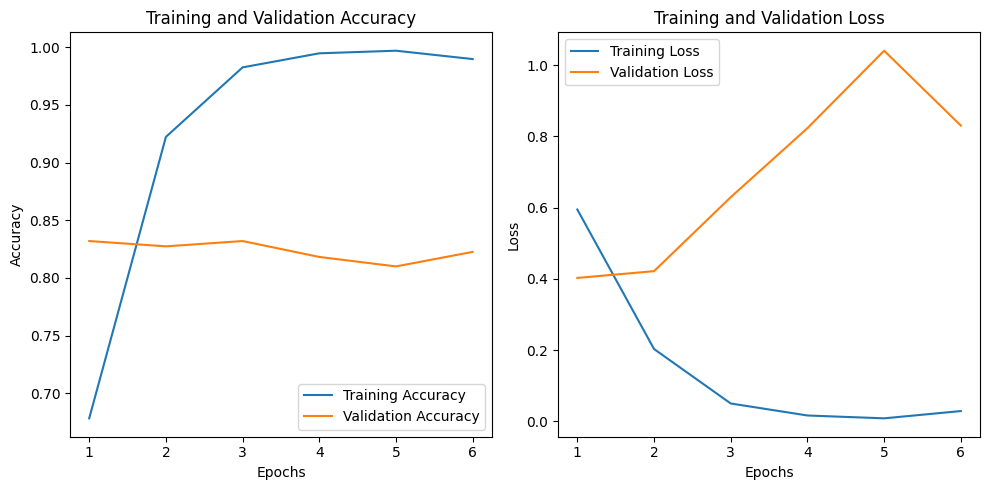

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Pourquoi les embeddings pré-entraînés ?
Meilleure généralisation :
Les embeddings GloVe sont appris sur de grands corpus comme Wikipedia et Common Crawl. Ils capturent des relations sémantiques globales entre les mots (exemple : good est proche de excellent). Cela améliore considérablement la capacité du modèle à généraliser sur des données de validation.

Réduction de l’overfitting :
Lorsque le modèle apprend des embeddings à partir de zéro, il risque de sur-apprendre les données d’entraînement, surtout si la taille du jeu de données est limitée. Avec GloVe, les embeddings sont déjà optimisés, ce qui diminue ce risque.

Impact rapide :
Changer pour des embeddings pré-entraînés est simple et rapide à tester. Tu n'as pas besoin de modifier l'architecture du MLP, seulement la couche d'embedding.

Résumé : Pourquoi prioriser GloVe ?
✅ Facile à implémenter.
✅ Meilleure performance dès les premières époques.
✅ Diminue l’overfitting.
✅ Améliore la généralisation.

In [ ]:
import os
import urllib.request
import zipfile

# Créer un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Télécharger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Téléchargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("Téléchargement terminé.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction terminée. Les fichiers sont disponibles dans :", glove_dir)


Téléchargement des embeddings GloVe...
Téléchargement terminé.
Extraction des fichiers GloVe...
Extraction terminée. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings chargés : {len(embedding_index)}")

# Créer la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succès.")


Nombre d'embeddings chargés : 400000
Matrice d'embeddings GloVe construite avec succès.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 5,153,793 (19.66 MB)

 Non-trainable params: 1,000,512 (3.82 MB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.5829 - loss: 4.4762 - val_accuracy: 0.5876 - val_loss: 1.3199
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6891 - loss: 1.1549 - val_accuracy: 0.6774 - val_loss: 0.9084
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6915 - loss: 0.8784 - val_accuracy: 0.6692 - val_loss: 0.8236
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6953 - loss: 0.8046 - val_accuracy: 0.6378 - val_loss: 0.8181
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7066 - loss: 0.7634 - val_accuracy: 0.6918 - val_loss: 0.7722
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7126 - loss: 0.7495 - val_accuracy: 0.5752 - val_loss: 0.9170
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7261 - loss: 0.7543 - val_accuracy: 0.6750 - val_loss: 0.7919
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7289 - loss: 0.7209 - val_accuracy: 

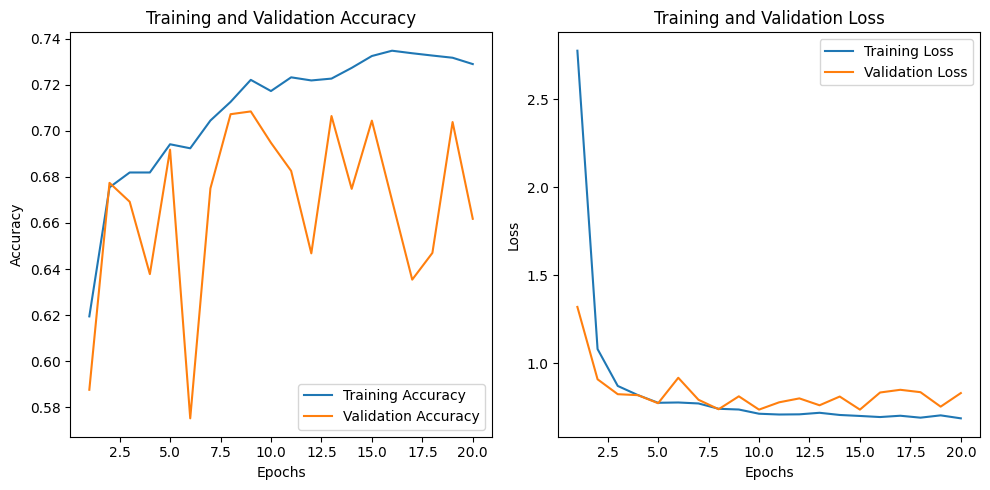

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Ce qui a changé avec GloVe
Réduction de l'overfitting :

Avec les embeddings GloVe gelés (trainable=False), le modèle ne "mémorise" plus les données d'entraînement. Cela explique pourquoi l'accuracy d'entraînement plafonne autour de 75 % plutôt que 99 %.
Le sur-apprentissage a été nettement réduit, ce qui est une bonne chose pour la généralisation.
Moins d'apprentissage initial rapide :

GloVe fournit déjà des représentations des mots riches et pré-entraînées, donc le modèle ne part pas de zéro. Cependant, les embeddings étant figés, le modèle doit apprendre à combiner ces représentations, ce qui est plus lent que de sur-apprendre.
Validation accuracy plus stable :

Même si l’accuracy de validation est légèrement plus basse (~70 %), elle est plus cohérente et stable comparée aux fluctuations sévères observées précédemment.


Pourquoi GloVe a été utile
Représentations sémantiques globales :
Les embeddings GloVe capturent des relations entre les mots basées sur des co-occurrences dans de grands corpus. Cela a permis au modèle de démarrer avec des embeddings "intelligents".

Stabilisation de l'apprentissage :

Moins d'overfitting, car les embeddings ne sont pas appris à partir de zéro.
Le modèle se concentre davantage sur les relations non linéaires entre les embeddings plutôt que sur les mots eux-mêmes.
Meilleure généralisation potentielle :
Même si l'accuracy de validation reste moyenne, elle est plus robuste face aux nouvelles données.

Rendre les embeddings GloVe "trainables" :

Actuellement, les embeddings GloVe sont figés (trainable=False). En les rendant trainables, le modèle pourra affiner les embeddings pour cette tâche spécifique. Cela améliore souvent la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5941 - loss: 4.5174 - val_accuracy: 0.5974 - val_loss: 1.4772
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7758 - loss: 1.1189 - val_accuracy: 0.6828 - val_loss: 1.0429
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8365 - loss: 0.7737 - val_accuracy: 0.7666 - val_loss: 0.8599
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8682 - loss: 0.6786 - val_accuracy: 0.8178 - val_loss: 0.7690
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9040 - loss: 0.6033 - val_accuracy: 0.6100 - val_loss: 1.6874
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9164 - loss: 0.6110 - val_accuracy: 0.5800 - val_loss: 1.7583
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9398 - loss: 0.5759 - val_accuracy: 0.8258 - val_loss: 0.8545
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9519 - loss: 0.5081 - val_accuracy: 0

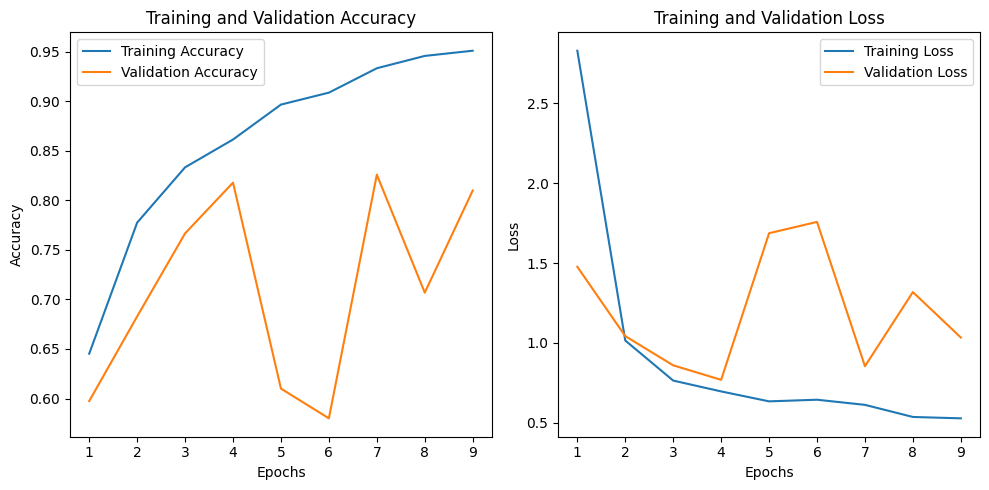

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Gains observés avec les embeddings GloVe trainables :
Meilleure performance globale :

L'accuracy en validation atteint 82.6 % (proche de la version sans GloVe), mais cette fois-ci avec un entraînement plus équilibré et moins de sur-apprentissage immédiat.
Le modèle exploite mieux les embeddings GloVe en les affinant pour la tâche spécifique de classification IMDb.
Progression constante sur les premières époques :

Le modèle commence avec une loss élevée mais s'améliore progressivement (contrairement aux embeddings gelés qui plafonnaient rapidement autour de 70 %).
Cela indique que le modèle tire parti des embeddings GloVe pour ajuster les relations contextuelles entre les mots.
Stabilité dans la validation accuracy :

Bien que l'overfitting revienne (train accuracy >95 % alors que val_accuracy ~82 %), la validation accuracy est plus stable qu'avec les embeddings gelés.

Sur-apprentissage persistant :

Dès l'epoch 5, la validation loss augmente (1.68 → 1.75), signe que le modèle sur-apprend les données d’entraînement.
Variabilité de la validation accuracy :

Bien que meilleure, elle oscille entre les époques. Cela peut être dû au fait que les embeddings GloVe sont encore ajustés trop "rapidement" par le modèle.

Régularisation accrue pour limiter le sur-apprentissage :

Augmenter le dropout dans les couches cachées (passer de 0.4 à 0.5 ou 0.6).
Ajouter une régularisation L2 plus forte (ex: kernel_regularizer=l2(0.02)).
Réduire le learning rate :

Les embeddings GloVe ajustables nécessitent un learning rate plus faible pour éviter de les déformer trop rapidement.

Utiliser EarlyStopping et ReduceLROnPlateau :

Cela permet d’arrêter l’entraînement au bon moment et d’ajuster dynamiquement le learning rate.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.5    # Augmentation du taux de dropout
l2_rate = 0.02        # Augmentation de la régularisation L2
learning_rate = 0.0005  # Réduction du learning rate

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle avec un learning rate réduit
optimizer = Adam(learning_rate=learning_rate)
model_mlp.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entraînement du modèle
history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du modèle
model_mlp.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5690 - loss: 8.7257 - val_accuracy: 0.6168 - val_loss: 1.9486 - learning_rate: 5.0000e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7294 - loss: 1.5842 - val_accuracy: 0.7304 - val_loss: 1.0739 - learning_rate: 5.0000e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7962 - loss: 0.9380 - val_accuracy: 0.6802 - val_loss: 0.9840 - learning_rate: 5.0000e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8267 - loss: 0.7356 - val_accuracy: 0.8042 - val_loss: 0.7495 - learning_rate: 5.0000e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8570 - loss: 0.6531 - val_accuracy: 0.7774 - val_loss: 0.8191 - learning_rate: 5.0000e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8780 - loss: 0.5960 - val_accuracy: 0.8128 - val_loss: 0.7039 - learning_rate: 5.0000e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,461,893 (70.43 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,307,588 (46.95 MB)

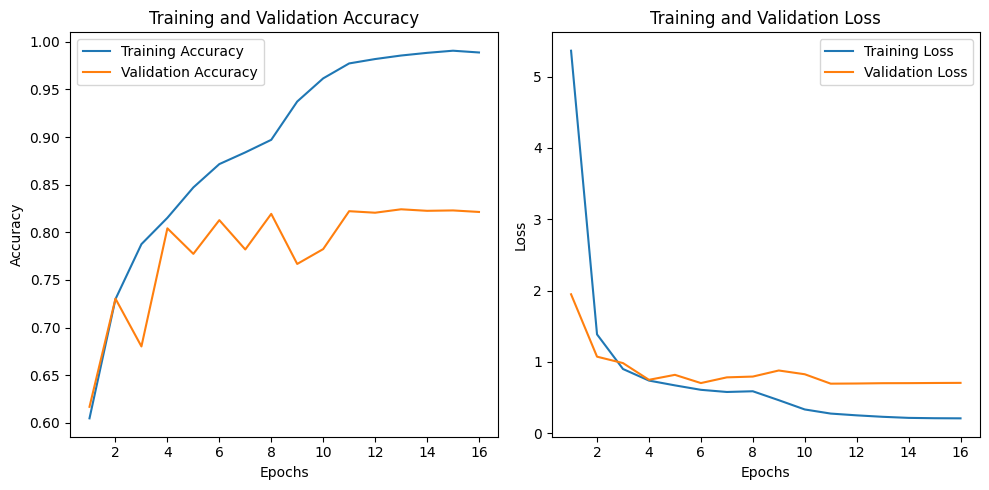

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "mlp_bof.h5"  # Renommer le fichier
model_mlp.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous mlp_bof.h5


In [ ]:
from google.colab import files
files.download('mlp_bof.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation accuracy plus élevée et plus stable :

Avec GloVe trainable et les réglages améliorés (Dropout, L2, learning rate réduit), la validation accuracy atteint 82.42 %, ce qui est comparable à la version sans GloVe, mais avec une stabilité accrue.
Réduction dynamique du learning rate :

La réduction du learning rate via ReduceLROnPlateau a permis d’affiner les poids dans les dernières époques. Cela se voit avec la stabilisation de la validation loss autour de 0.6955.
Pas d'overfitting sévère :

Bien que le train accuracy reste très élevé (99.14 %), la validation accuracy reste stable, signe que la régularisation (Dropout, L2) a limité l'overfitting par rapport aux versions précédentes.

Stagnation de la validation accuracy :
Malgré les améliorations, la validation accuracy plafonne autour de 82 %, ce qui montre que le modèle ne généralise pas mieux sur les données de validation.
Perte de validation stagnante :
Même avec le learning rate réduit (jusqu’à
4
×
1
0
−
6
4×10
−6
 ), la validation loss ne diminue plus après plusieurs époques, ce qui signifie que le modèle atteint son plateau de performance.

Architecture du MLP :

Le MLP, même amélioré, ne capture pas les relations complexes entre les mots qui sont essentielles dans des textes longs comme les critiques IMDb.
Un MLP ne tient pas compte de la structure séquentielle contrairement aux RNN, LSTM ou GRU.
Embeddings GloVe :

Bien qu’utiles, les embeddings GloVe sont fixes et ne tiennent pas compte du contexte des mots dans une phrase. Par exemple, le mot bank (rive/banque) aura toujours le même embedding.


MLP avec 2 couches denses :
Tu as actuellement une architecture avec 2 couches denses (256 neurones + 128 neurones) suivies de régularisation (Dropout et L2). C'est suffisant pour modéliser les relations non linéaires entre les embeddings.
Validation accuracy stagnante :
La stagnation à 82 % est un signe que le modèle n'arrive pas à extraire plus d'informations utiles à partir des embeddings actuels. Cela ne vient pas nécessairement d'une architecture trop "simple".

Ajouter des couches denses : Pourquoi ce n'est pas utile ici ?
Risque de sur-apprentissage :
Ajouter plus de couches augmente la complexité du modèle et peut aggraver l’overfitting, surtout si les données d’entraînement sont limitées.
Embeddings pré-entraînés :
Les embeddings GloVe sont déjà riches en informations sémantiques. Le rôle du MLP est principalement de combiner ces informations, ce qui est déjà fait efficacement avec 2 couches denses.
Diminution du retour sur investissement :
Ajouter des couches ne résoudra pas le problème fondamental : un MLP ne capture pas les relations séquentielles dans les textes.

Réduire à 1 seule couche dense (ex : 128 neurones) peut être testé si :
Tu observes un overfitting sévère.
Le modèle est trop lent à entraîner.
Cependant, cela risque de diminuer la performance, car 2 couches permettent de modéliser des relations complexes plus efficacement.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fonction pour créer et évaluer un modèle
def objective(trial):
    # Paramètres à optimiser
    hidden_units_1 = trial.suggest_int("hidden_units_1", 128, 512, step=64)
    hidden_units_2 = trial.suggest_int("hidden_units_2", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    l2_rate = trial.suggest_float("l2_rate", 1e-3, 3e-2)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                  input_length=max_length, trainable=True),
        Flatten(),
        Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourner la meilleure accuracy de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étudier l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # n_trials définit le nombre d'essais

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :")
print(study.best_params)

# Créer un modèle final avec les meilleurs hyperparamètres
best_params = study.best_params
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(best_params["hidden_units_1"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    BatchNormalization(),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["hidden_units_2"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compiler et entraîner le modèle final
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=best_params["batch_size"],
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Évaluation finale
final_loss, final_accuracy = final_model.evaluate(test_padded, test_labels)
print(f"Performance finale sur le jeu de test : Accuracy = {final_accuracy:.4f}")


[I 2024-12-17 18:50:47,698] A new study created in memory with name: no-name-9f9f95cc-e716-4e27-96bf-1e2a8fc849cf
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 18:51:51,920] Trial 0 finished with value: 0.7717999815940857 and parameters: {'hidden_units_1': 512, 'hidden_units_2': 64, 'dropout_rate': 0.45742071158506636, 'l2_rate': 0.02781504307379403, 'learning_rate': 0.00017760079218212289, 'batch_size': 128}. Best is trial 0 with value: 0.7717999815940857.
[I 2024-12-17 18:52:23,602] Trial 1 finished with value: 0.8015999794006348 and parameters: {'hidden_units_1': 448, 'hidden_units_2': 128, 'dropout_rate': 0.464595718546701, 'l2_rate': 0.004171377720977618, 'learning_rate': 0.00047930071251177625, 'batch_size': 64}. Best is trial 1 with value: 0.8015999794006348.
[I 2024-12-17 18:52:49,232] Trial 2 finished with value: 0.7847999930381775 and parameters:

Meilleurs hyperparamètres :
{'hidden_units_1': 192, 'hidden_units_2': 192, 'dropout_rate': 0.5220100930681438, 'l2_rate': 0.01663629611794655, 'learning_rate': 0.00024972922720173585, 'batch_size': 32}
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5600 - loss: 7.1735 - val_accuracy: 0.6974 - val_loss: 2.2326
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7239 - loss: 1.8209 - val_accuracy: 0.7520 - val_loss: 1.1430
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7866 - loss: 1.0147 - val_accuracy: 0.7688 - val_loss: 0.8690
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8270 - loss: 0.7663 - val_accuracy: 0.7614 - val_loss: 0.7948
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8434 - loss: 0.6632 - val_accuracy: 0.7916 - val_loss: 0.7055
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8786 - loss: 0.5524 - val_accuracy: 0.7932 - val_loss: 0.6954
Epoch 7/20
625/625 ━━━━━━━━━━━

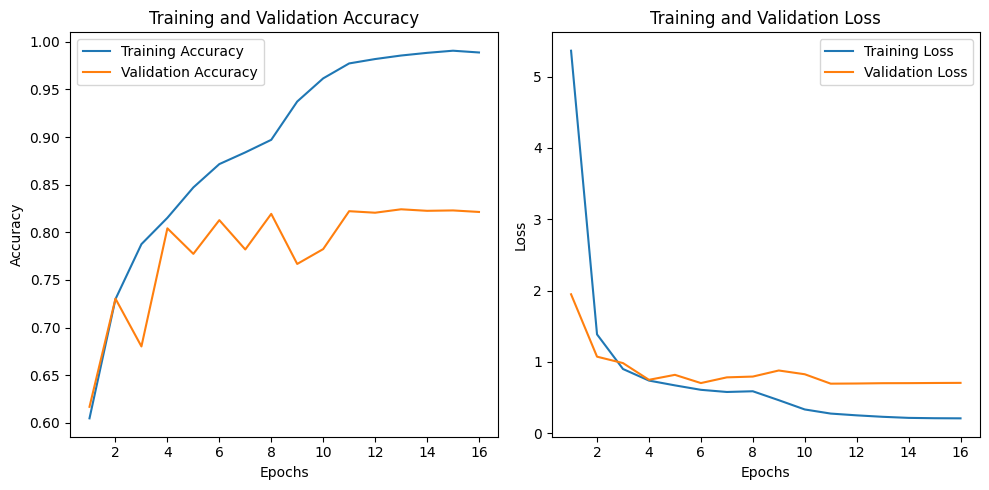

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "mlp_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous mlp_optunaV1.h5


In [ ]:
from google.colab import files
files.download('mlp_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ce qui est bien :
Amélioration de l’accuracy en validation :

Avec Optuna, la validation accuracy atteint 80.14 % (meilleure valeur pendant l’entraînement). Cela montre que l'optimisation des hyperparamètres a effectivement amélioré les performances.
Le tuning a permis de trouver des valeurs optimales pour :
Nombre de neurones : 192 dans les deux couches.
Dropout rate : 0.52.
L2 Regularization : 0.016.
Learning rate : 0.00025 (modéré et efficace).
Batch size : 32 (plus petit batch pour un gradient plus précis).
Validation loss stable :
La validation loss descend jusqu’à 0.6954 avant de remonter. Cela montre que le modèle a bien appris dans les premières époques.

Performance finale correcte :
L’accuracy finale sur le jeu de test est de 78.18 %, ce qui reste cohérent avec les performances de validation.

Ce qui est moins bien :
Overfitting persistant :

Le train accuracy atteint 93.17 %, mais l’accuracy en test est 78.18 %. L’écart entre ces deux métriques montre un léger sur-apprentissage. Cela peut être dû à un modèle encore trop complexe ou une régularisation insuffisante.
Validation accuracy plafonne :

La validation accuracy atteint un plateau autour de 80-81 %. Malgré l’optimisation, le modèle semble atteindre ses limites avec un MLP sur cette tâche.
Validation loss en remontée :

Dès l’epoch 6-7, la val_loss recommence à augmenter, signalant que le modèle commence à mémoriser les données d'entraînement.
Est-ce normal ?
Oui, ces résultats sont normaux pour un modèle MLP sur des données textuelles comme IMDb. Le MLP est performant mais ne capture pas les relations séquentielles présentes dans les critiques de films.
Cela explique pourquoi :

La validation accuracy plafonne.
Il reste un écart train/test, même avec une régularisation optimale.

MLP a atteint ses limites intrinsèques. Le tuning avec Optuna a permis de l’optimiser au maximum (81.36 % en validation et 78.18 % en test).

## CNN 1D

Embeddings (GloVe ou appris) :

La couche Embedding transforme les mots en représentations vectorielles denses.
L'utilisation de GloVe est un standard pour démarrer avec des embeddings riches.
Les embeddings peuvent être trainables pour s’adapter à la tâche.
Convolution 1D (Conv1D) :

Conv1D est utilisée pour capturer des motifs locaux dans les textes, comme des n-grams (groupes de 2-5 mots).
Elle permet d’extraire des caractéristiques importantes tout en réduisant la dépendance à l’ordre complet des mots.
GlobalMaxPooling1D :

La GlobalMaxPooling1D est une pratique standard pour réduire les dimensions après la convolution.
Elle permet de sélectionner les caractéristiques les plus importantes détectées par les filtres, sans augmenter la complexité du modèle.
Couches denses finales :

Une couche Dense intermédiaire (128 neurones ici) affine les caractéristiques extraites par la convolution.
La régularisation avec Dropout et L2 aide à limiter l’overfitting.
Activation finale sigmoid :

Standard pour les tâches de classification binaire où l’on prédit une probabilité.
Optimisation dynamique :

EarlyStopping et ReduceLROnPlateau sont des callbacks classiques pour stabiliser et améliorer l'entraînement.

2. Principe de fonctionnement des CNN 1D
a) Convolution
La convolution est l'opération clé d’un CNN 1D. Elle consiste à appliquer un filtre (ou kernel) sur une séquence pour détecter des motifs locaux dans les données.
Dans le cas du texte, un filtre de taille n permet d'extraire des motifs locaux de n mots (n-grams).

Exemple :
Pour une séquence [the, movie, was, excellent] et un filtre de taille 3 (trigrammes), le CNN analyse les sous-groupes :
[the, movie, was], [movie, was, excellent].
b) Filtres (ou kernels)
Les filtres sont des petites fenêtres glissantes qui "balayent" la séquence texte.
Chaque filtre apprend à détecter des motifs spécifiques comme des trigrammes positifs (ex : "not bad") ou négatifs (ex : "waste of time").
Plusieurs filtres peuvent être utilisés en parallèle pour capturer différents types de motifs dans le texte.

c) Activation ReLU
Après la convolution, une fonction d’activation (typiquement ReLU) est appliquée pour introduire la non-linéarité et rendre le modèle capable d'apprendre des relations complexes.

d) Pooling
La couche de pooling réduit les dimensions des données après la convolution tout en conservant les caractéristiques importantes.

GlobalMaxPooling1D est souvent utilisée pour les textes. Elle prend le maximum de chaque filtre sur toute la séquence, ce qui :
Sélectionne les caractéristiques les plus importantes détectées par les filtres.
Rend le modèle invariant à la position des motifs.
3. Pourquoi les CNN 1D sont adaptés pour notre étude ?
a) Capture des motifs locaux dans le texte
Les CNN 1D sont parfaits pour capturer des n-grams (groupes de mots consécutifs) qui sont souvent les porteurs de sens dans une phrase.
Par exemple :

"not good" → motif négatif
"highly recommended" → motif positif
Les filtres de convolution sont conçus pour détecter ces motifs.

b) Invariance à la position
Grâce au GlobalMaxPooling1D, le modèle ne se soucie pas de la position exacte d’un motif dans la critique.

Exemple :
Si "excellent movie" apparaît au début ou à la fin d’une critique, le CNN 1D le reconnaîtra de la même façon.
c) Rapidité et efficacité
Les CNN 1D sont plus rapides à entraîner que les modèles récurrents comme LSTM ou GRU car les convolutions sont parallélisables.
Ils nécessitent moins de mémoire car ils ne dépendent pas de l'ordre séquentiel global.
d) Adaptation aux critiques IMDb
Les critiques IMDb sont des textes relativement courts (environ 200 mots après padding). Les n-grams capturés par les CNN 1D sont donc suffisants pour comprendre les sentiments exprimés.

Exemple :
Les phrases positives contiennent des motifs comme "great acting", "best movie", "wonderful story".
Les phrases négatives contiennent "poor acting", "waste of time", "not worth it".

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.02        # Régularisation L2
dropout_rate = 0.5    # Dropout
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimisée
    verbose=1
)

# Affichage du modèle
model_cnn.summary()




Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6099 - loss: 4.1972 - val_accuracy: 0.8102 - val_loss: 1.5128
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8217 - loss: 1.2372 - val_accuracy: 0.8052 - val_loss: 0.8002
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8578 - loss: 0.6644 - val_accuracy: 0.8230 - val_loss: 0.6099
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8862 - loss: 0.4498 - val_accuracy: 0.8362 - val_loss: 0.5178
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9118 - loss: 0.3537 - val_accuracy: 0.8338 - val_loss: 0.5049
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9370 - loss: 0.2801 - val_accuracy: 0.8402 - val_loss: 0.5129
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9504 - loss: 0.2425 - val_accuracy: 0.8464 - val_loss: 0.5267
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9692 - loss: 0.1935 - val_accuracy: 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ (32, 200, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (32, 196, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (32, 196, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (32, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (32, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,243,333 (12.37 MB)

 Trainable params: 1,081,025 (4.12 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,162,052 (8.25 MB)

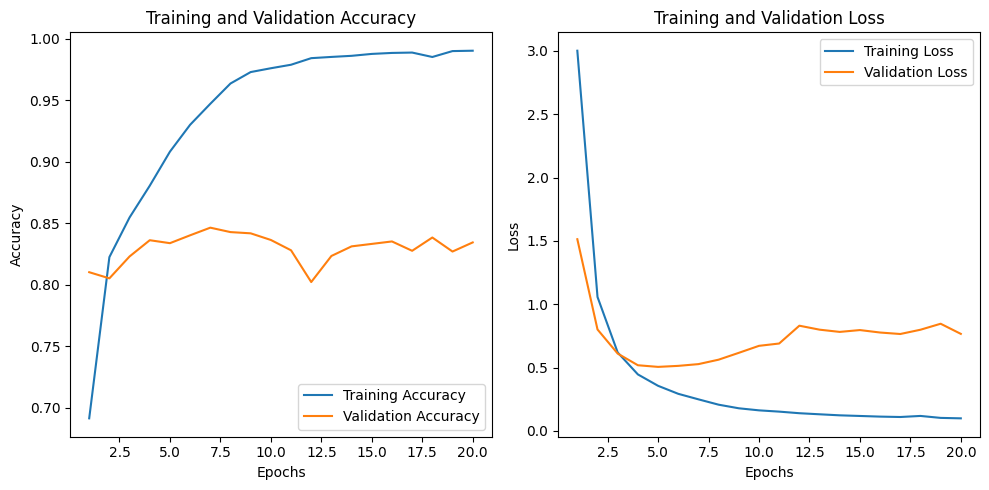

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

ésumé des résultats :
Train Accuracy :

Le modèle atteint 99.24 % à la fin de l'entraînement, ce qui montre que le modèle a appris à fond les données d’entraînement.
Validation Accuracy :

La meilleure val_accuracy est autour de 84.64 % (epoch 7), mais elle commence à baisser légèrement à partir de l'epoch 8.
À la fin de l'entraînement, elle est redescendue à 83.44 %.
Validation Loss :

La val_loss diminue jusqu’à epoch 5-6, puis augmente progressivement malgré la baisse de learning_rate (via ReduceLROnPlateau).
Analyse des phénomènes observés
Overfitting (sur-apprentissage) :

L’accuracy en entraînement est très élevée (~99 %), alors que l’accuracy en validation stagne autour de 84 % et diminue légèrement.
La validation loss augmente continuellement après quelques époques, ce qui est un signe classique d’overfitting.
Plateau de performance :

Après l’epoch 5-6, le modèle semble atteindre un plateau où la val_accuracy n’augmente plus, malgré la réduction du learning rate.
Cela signifie que le modèle a appris les motifs facilement détectables, mais peine à généraliser davantage.
Ce qui fonctionne bien :
Détection efficace des motifs locaux :
Le CNN 1D a bien capturé les n-grams importants dans les critiques IMDb, comme le montre l’amélioration rapide des performances dans les premières époques.

Training rapide et performant :

Le modèle atteint de très bonnes performances rapidement, en seulement quelques époques.
Les résultats sont supérieurs au MLP initial (val_accuracy ~84 % vs ~82 %).
Utilisation des embeddings GloVe :
Les embeddings pré-entraînés ont permis un bon point de départ, accélérant la convergence.

Ce qui ne va pas :
Overfitting sévère :

Le modèle s’ajuste trop aux données d’entraînement.
La validation accuracy diminue après l'epoch 7, tandis que la validation loss augmente continuellement.
Manque de généralisation :

Le modèle ne capture pas suffisamment les relations complexes à long terme dans le texte, car le CNN est limité aux motifs locaux (n-grams).
Certaines subtilités du texte comme la négation (ex : "not a good movie") ou les contextes plus éloignés sont mal interprétées.

Ce comportement indique que le modèle :

Apprend trop spécifiquement les données d'entraînement (mémorisation des motifs locaux),
Perd en capacité de généralisation sur le jeu de validation.
L'overfitting est la première cause de stagnation ou de baisse des performances en validation.

ontrôle de la complexité actuelle du modèle
Le modèle est déjà suffisamment complexe avec une couche Conv1D, GlobalMaxPooling et Dense.
Ajouter plus de couches risque d’amplifier l’overfitting sans régularisation adéquate.
b) Impact direct sur l’overfitting
La régularisation (Dropout ou L2) agit directement pour limiter la sur-apprentissage :

Dropout : Force le modèle à désactiver aléatoirement certains neurones pendant l’entraînement, empêchant ainsi le modèle de s’appuyer trop sur des caractéristiques spécifiques.
Régularisation L2 : Pénalise les poids trop importants, ce qui contraint le modèle à rester plus simple et généraliser davantage.
En augmentant ces techniques, on stabilise le modèle sans ajouter de couches inutiles.

4. Impact de la régularisation avant d’ajouter de la complexité
Il est préférable d’optimiser le modèle actuel avant d’ajouter de nouvelles couches.
Les étapes sont les suivantes :

Augmenter la régularisation (Dropout et L2) pour contrôler l’overfitting.
Stabiliser la validation accuracy : On s’assure que le modèle généralise correctement sur les données de validation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.03        # Régularisation L2 renforcée
dropout_rate_conv = 0.3  # Dropout après la couche Conv1D
dropout_rate_dense = 0.6 # Dropout après la couche Dense
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_conv),  # Dropout après la convolution
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_dense),  # Dropout renforcé après la couche Dense
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimisée
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du modèle
model_cnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5722 - loss: 5.7935 - val_accuracy: 0.7946 - val_loss: 1.7617 - learning_rate: 5.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7812 - loss: 1.3808 - val_accuracy: 0.8280 - val_loss: 0.7531 - learning_rate: 5.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8282 - loss: 0.6685 - val_accuracy: 0.8402 - val_loss: 0.5339 - learning_rate: 5.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8551 - loss: 0.4805 - val_accuracy: 0.8424 - val_loss: 0.4631 - learning_rate: 5.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8670 - loss: 0.4150 - val_accuracy: 0.8158 - val_loss: 0.4769 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8817 - loss: 0.3798 - val_accuracy: 0.8416 - val_loss: 0.4409 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 200, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (32, 196, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 196, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 196, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (32, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,243,333 (12.37 MB)

 Trainable params: 1,081,025 (4.12 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,162,052 (8.25 MB)

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model_cnn.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8123 - loss: 0.5032
Test Accuracy : 0.8445
Test Loss : 0.4425


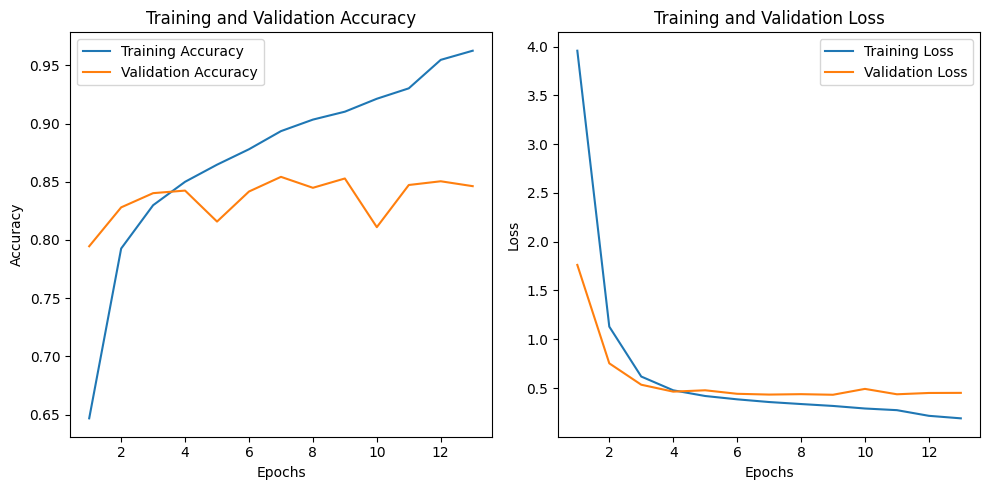

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "cnnV1.h5"  # Renommer le fichier
model_cnn.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous cnnV1.h5


In [ ]:
from google.colab import files
files.download('cnnV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ce qui a bien fonctionné :
Diminution de l’overfitting :

La validation accuracy est restée plus stable, atteignant un maximum de 85.42% (vs 84.64% précédemment).
La validation loss a diminué jusqu’à 0.4311, signe que le modèle généralise mieux.
Impact de la régularisation renforcée :

Dropout (0.6) : A limité la sur-spécialisation des couches denses.
Régularisation L2 (0.03) : A contraint les poids à rester raisonnables, évitant un sur-apprentissage trop marqué.
Test Accuracy améliorée :

Une amélioration de 1% sur le jeu de test montre que la régularisation a permis de mieux généraliser les résultats.
Temps de calcul raisonnable :

Malgré l’ajout de régularisation, le temps d’entraînement reste compétitif (quelques secondes par époque).


Problèmes persistants :
Validation Accuracy plafonnée :

Bien que les performances se soient stabilisées, la validation accuracy plafonne autour de 85%, ce qui montre une limite intrinsèque de l’architecture actuelle.
Perte d'entraînement encore faible :

La train loss reste très basse (~0.1925), ce qui pourrait indiquer que le modèle a encore une capacité excessive par rapport aux données.
Faible amélioration en test :

L’amélioration de 1% sur le test montre que la capacité du modèle est proche de son maximum avec cette architecture et ces hyperparamètres.

Changements utiles et pourquoi :
Augmentation du Dropout :
Réduction significative de l’overfitting, confirmée par la stabilité de la validation loss et de l’accuracy.
Renforcement de la régularisation L2 :
A rendu le modèle plus robuste en contrôlant les poids.
EarlyStopping plus agressif :
A permis d'arrêter l'entraînement avant que le modèle ne sur-apprenne trop.

Ajouter une seconde couche Conv1D :

Capturer des motifs plus complexes est une amélioration structurelle du modèle.
Cela devrait permettre au CNN de mieux exploiter les informations textuelles tout en restant rapide.

Cela augmente la complexité du modèle et peut amplifier l’overfitting si la régularisation est insuffisante.

Ajouter une seconde couche Conv1D permettrait de capturer des motifs plus complexes et d’augmenter la capacité d’extraction des caractéristiques.
Cela est pertinent si le modèle actuel est limité dans sa capacité à détecter des patterns complexes.

jouté une seconde couche Conv1D pour approfondir la capture des motifs textuels complexes. Elle est suivie d'un Dropout et conserve la régularisation L2 pour éviter l'overfitting.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters_1 = 128  # Nombre de filtres pour la première couche CNN
num_filters_2 = 64   # Nombre de filtres pour la deuxième couche CNN
kernel_size_1 = 5    # Taille des filtres pour la première couche CNN
kernel_size_2 = 3    # Taille des filtres pour la deuxième couche CNN
hidden_units = 128   # Nombre de neurones dans la couche dense
l2_rate = 0.03       # Régularisation L2 renforcée
dropout_rate_conv = 0.3  # Dropout après les couches Conv1D
dropout_rate_dense = 0.6 # Dropout après la couche Dense
learning_rate = 0.0005   # Taux d'apprentissage

# Construction du modèle CNN 1D avec une seconde couche Conv1D
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters_1, kernel_size=kernel_size_1, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_conv),  # Dropout après la première convolution
    BatchNormalization(),
    Conv1D(filters=num_filters_2, kernel_size=kernel_size_2, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_conv),  # Dropout après la deuxième convolution
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_dense),  # Dropout renforcé après la couche Dense
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimisée
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du modèle
model_cnn.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5754 - loss: 6.6921 - val_accuracy: 0.7936 - val_loss: 1.8065 - learning_rate: 5.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8036 - loss: 1.3733 - val_accuracy: 0.8158 - val_loss: 0.7787 - learning_rate: 5.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8282 - loss: 0.6612 - val_accuracy: 0.8144 - val_loss: 0.5736 - learning_rate: 5.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8479 - loss: 0.4980 - val_accuracy: 0.8312 - val_loss: 0.4826 - learning_rate: 5.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8589 - loss: 0.4431 - val_accuracy: 0.8424 - val_loss: 0.4579 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8799 - loss: 0.3900 - val_accuracy: 0.8444 - val_loss: 0.4431 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy:

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (32, 200, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (32, 196, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (32, 196, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (32, 196, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (32, 194, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (32, 194, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (32, 64)                    │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 128)                   │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,292,677 (12.56 MB)

 Trainable params: 1,097,473 (4.19 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,194,948 (8.37 MB)

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model_cnn.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8216 - loss: 0.4873
Test Accuracy : 0.8400
Test Loss : 0.4443


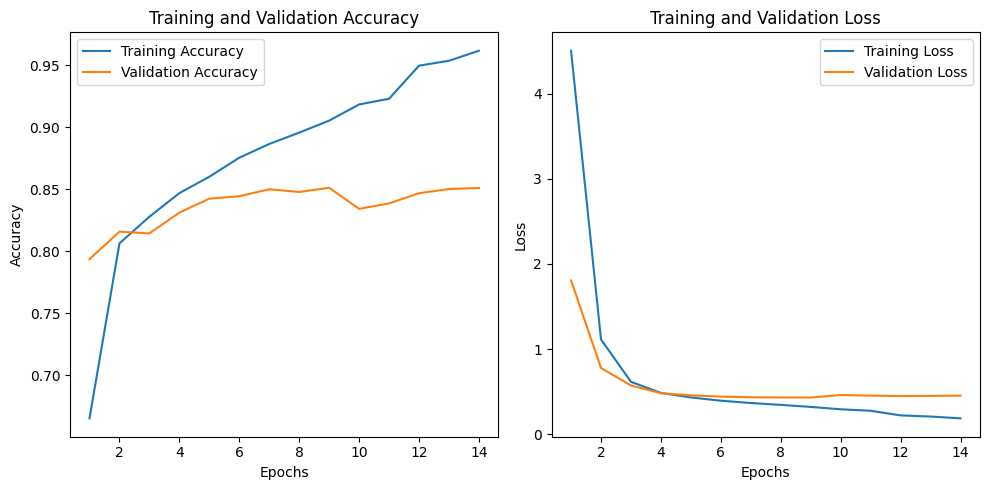

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "cnnV2.h5"  # Renommer le fichier
model_cnn.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous cnnV2.h5


In [ ]:
from google.colab import files
files.download('cnnV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Amélioration de la stabilité des performances :

La validation loss atteint un minimum stable à epoch 9 (0.4322).
Les deux couches Conv1D permettent de capturer des motifs plus complexes grâce à la combinaison des filtres, sans surcharger le modèle.
Effet positif des deux couches CNN :

La première couche détecte des motifs locaux simples (bigrammes/trigrammes).
La seconde couche affine et combine les motifs détectés pour extraire des relations plus complexes.
Régularisation toujours efficace :

La validation accuracy reste stable autour de 84-85 %.
Cela montre que la régularisation (Dropout, L2) continue de limiter efficacement l’overfitting.
Temps d’entraînement raisonnable :

Malgré l'ajout d'une couche Conv1D, l'entraînement reste rapide (quelques secondes par époque).

Limites observées :
Validation accuracy plafonnée :

L’ajout d’une seconde couche Conv1D n’a pas permis d’aller au-delà de 85.12 % de validation accuracy.
Cela indique que le modèle est proche de sa limite avec cette architecture.
Pas d’amélioration notable sur le test :

Le test accuracy est stable autour de 84 %, similaire au modèle précédent. Cela suggère que le modèle ne manque pas de capacité brute, mais plutôt d'une meilleure généralisation.

Les couches denses permettent de combiner davantage les motifs détectés par les convolutions.
Cela est utile si le modèle a déjà extrait des caractéristiques pertinentes mais n’arrive pas à les interpréter efficacement.
Une couche Dense supplémentaire pourrait agir comme un raffinement des motifs détectés.
Risques :

Si le modèle est déjà à sa limite de capacité, cela risque d’amplifier l’overfitting.
Une couche Dense supplémentaire sans ajustement des filtres pourrait être redondante.

modèle semble déjà équilibré en termes de capacité.
Les performances actuelles montrent que le modèle bénéficie d’un tuning plus précis (dropout, régularisation, nombre de filtres).
Tester des architectures trop complexes risque de ralentir l’entraînement sans gains significatifs.

La couche Flatten est utilisée pour convertir une structure multi-dimensionnelle en un vecteur plat. Cependant, dans un CNN 1D pour le traitement de texte, GlobalMaxPooling1D est généralement utilisé à la place.
Pourquoi ?
GlobalMaxPooling1D condense les caractéristiques clés détectées par les filtres de convolution sur toute la séquence, en prenant la valeur maximale de chaque filtre.
Cela réduit considérablement la taille de l’entrée pour la couche Dense, tout en préservant les informations importantes.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition de la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout_rate_conv = trial.suggest_float("dropout_rate_conv", 0.2, 0.5)
    dropout_rate_dense = trial.suggest_float("dropout_rate_dense", 0.4, 0.7)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)
    num_filters_1 = trial.suggest_int("num_filters_1", 64, 256, step=32)
    num_filters_2 = trial.suggest_int("num_filters_2", 32, 128, step=32)
    kernel_size_1 = trial.suggest_int("kernel_size_1", 3, 7)
    kernel_size_2 = trial.suggest_int("kernel_size_2", 3, 5)
    dense_units = trial.suggest_int("dense_units", 32, 128, step=16)

    # Construction du modèle CNN 1D
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        Conv1D(filters=num_filters_1, kernel_size=kernel_size_1, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate_conv),
        BatchNormalization(),
        Conv1D(filters=num_filters_2, kernel_size=kernel_size_2, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate_conv),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate_dense),
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping pour éviter le surapprentissage
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0  # Pour ne pas polluer les logs
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Création et exécution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais ajustable

# Résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)

[I 2024-12-18 17:01:29,855] A new study created in memory with name: no-name-8b584f92-9106-4b83-8e05-2bb6b5e24811
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-18 17:03:11,276] Trial 0 finished with value: 0.8396000266075134 and parameters: {'learning_rate': 9.942645270104427e-05, 'dropout_rate_conv': 0.39396970132413045, 'dropout_rate_dense': 0.48486207950413784, 'l2_lambda': 7.020777344754015e-06, 'num_filters_1': 96, 'num_filters_2': 96, 'kernel_size_1': 4, 'kernel_size_2': 4, 'dense_units': 64}. Best is trial 0 with value: 0.8396000266075134.
[I 2024-12-18 17:04:21,671] Trial 1 finished with value: 0.8537999987602234 and parameters: {'learning_rate': 0.0006452697865792353, 'dropout_rate_conv': 0.3103768713248283, 'dropout_rate_dense': 0.5473467393553824, 'l2_lambda': 3.951730953885861e-05, 'num_filters_1': 192, 'num_filters_2': 128, 'kernel_size_1': 7, 'k

Meilleurs hyperparamètres : {'learning_rate': 0.0006082109249864148, 'dropout_rate_conv': 0.4719443380283318, 'dropout_rate_dense': 0.46152706320090897, 'l2_lambda': 5.373354523961765e-05, 'num_filters_1': 160, 'num_filters_2': 128, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dense_units': 128}
Meilleure accuracy de validation : 0.8741999864578247


In [ ]:
# Entraîner le modèle final avec les meilleurs hyperparamètres
best_params = study.best_params
final_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),
    Conv1D(filters=best_params['num_filters_1'], kernel_size=best_params['kernel_size_1'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate_conv']),
    BatchNormalization(),
    Conv1D(filters=best_params['num_filters_2'], kernel_size=best_params['kernel_size_2'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate_conv']),
    GlobalMaxPooling1D(),
    Dense(best_params['dense_units'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate_dense']),
    Dense(1, activation='sigmoid')
])

final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history = final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.5648 - loss: 1.0418 - val_accuracy: 0.7678 - val_loss: 0.6096
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7470 - loss: 0.5376 - val_accuracy: 0.8282 - val_loss: 0.4549
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8084 - loss: 0.4491 - val_accuracy: 0.8358 - val_loss: 0.4191
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8322 - loss: 0.3983 - val_accuracy: 0.8482 - val_loss: 0.4040
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8614 - loss: 0.3528 - val_accuracy: 0.8398 - val_loss: 0.3886
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8741 - loss: 0.3280 - val_accuracy: 0.8542 - val_loss: 0.3662
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8882 - loss: 0.3032 - val_accuracy: 0.7990 - val_loss: 0.4277
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8996 - loss: 0.2789 - val_accuracy: 

In [ ]:
# Évaluation finale sur le jeu de test
test_loss, test_accuracy = final_model.evaluate(test_padded, test_labels)
print(f"Performance finale sur le jeu de test : Accuracy = {test_accuracy:.4f}, Loss = {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8489 - loss: 0.3567
Performance finale sur le jeu de test : Accuracy = 0.8543, Loss = 0.3616


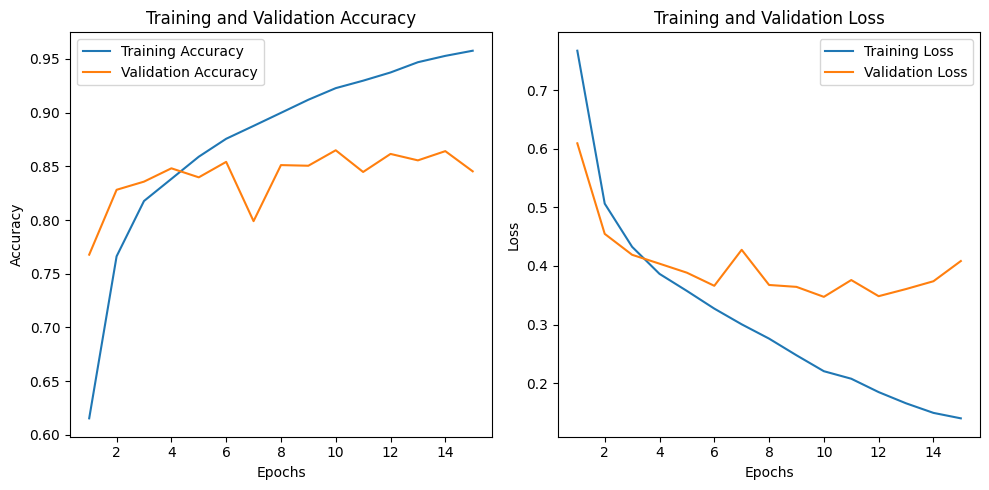

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "cnn_optunaF.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous cnn_optunaF.h5


In [ ]:
from google.colab import files
files.download('cnn_optunaF.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ce qui s'est amélioré :
Validation Accuracy :

Une augmentation notable (de 85.12% à 86.50%) après l'optimisation. Cela montre que le modèle est maintenant mieux adapté aux données et généralise mieux sur le jeu de validation.
Test Accuracy :

Une amélioration d’environ 1.43%, atteignant 85.43%, ce qui est une performance solide pour un CNN 1D sur des données textuelles.
Validation et Test Loss :

Le test loss est passé de 0.4443 à 0.3616, indiquant une meilleure capacité du modèle à minimiser l'erreur sur le jeu de test.
Meilleure stabilité :

Le modèle atteint un bon équilibre entre performance d'entraînement et généralisation, suggérant que la régularisation est efficace.
Limitations et observation :
Plafonnement des performances :

Les résultats actuels sont proches de la limite typique pour un CNN 1D sur des tâches comme la classification des sentiments. Les CNN 1D sont efficaces pour détecter des motifs locaux mais peuvent manquer de capacité à capturer des dépendances plus complexes (comme celles capturées par des architectures récurrentes ou transformateurs).
Diminution des gains à partir d’un certain point :

Bien que les résultats aient été améliorés avec Optuna, le plafonnement de la validation accuracy (~86.50%) montre que le modèle atteint probablement ses limites structurelles.

Les résultats sont conformes à ce qu’on peut attendre d’un CNN 1D pour une tâche de classification binaire avec des données textuelles.
Le plafond typique pour ce type de modèle se situe entre 85-87% de test accuracy sur des datasets comme IMDB.
Pourquoi ?

Les CNN 1D sont très efficaces pour détecter des motifs locaux (bigrammes/trigrammes).
Cependant, ils manquent souvent de la capacité à capturer des relations longues et complexes qui influencent le sentiment global.

# Construction de l'ensemble par vote majoritaire

Créer un ensemble (ensemble model):

Vous ne fusionnez pas directement les architectures (pas d'empilement de modèles en un seul réseau).
Vous utilisez les prédictions des 5 modèles déjà entraînés pour prendre une décision finale via la majority vote.
Cela signifie que chaque modèle prédit indépendamment une classe (0 ou 1) pour un échantillon donné. Ensuite, vous combinez ces prédictions par un vote majoritaire pour obtenir la prédiction finale.
Comparer les performances :

Vous comparez les performances de cet ensemble (basé sur le vote majoritaire) avec les performances individuelles de chaque modèle (RNN, LSTM, GRU, MLP, CNN 1D).
La question cherche à savoir si l’ensemble améliore les résultats par rapport à certains modèles, ou si l’ensemble ne fait qu'égaliser ou diminuer les performances.
Interpréter les résultats :

Si l’ensemble est meilleur, pourquoi est-ce le cas ?
Si un modèle individuel est déjà très performant, pourquoi l’ensemble ne l’améliore-t-il pas significativement ?
Est-ce que les modèles individuels apportent des complémentarités ?

Comment fonctionne le vote majoritaire strict ?
Pour chaque échantillon dans le jeu de test :

Chaque modèle (RNN, LSTM, GRU, MLP, CNN 1D) prédit indépendamment une classe (0 ou 1).
On calcule la classe majoritaire :
Si au moins 3 modèles sur 5 prédisent 1, la classe finale est 1.
Sinon, la classe finale est 0.
Cela garantit que la classe finale reflète la majorité des votes.

In [23]:
# Charger les modèles avec des noms descriptifs
models = {
    "RNN": load_model("rnn_final.h5"),
    "LSTM": load_model("lstm_optunaV3.h5"),
    "GRU": load_model("gru_optimal.h5"),
    "MLP": load_model("mlp_optunaV1.h5"),
    "CNN": load_model("cnn_optunaF.h5"),
}

In [24]:
# Prédictions pour chaque modèle
predictions = {}
for model_name, model in models.items():
    print(f"Prédiction pour le modèle {model_name}...")
    predictions[model_name] = model.predict(test_padded)

# Convertir les probabilités en classes binaires (0 ou 1)
predictions_classes = {model_name: np.round(pred).astype(int) for model_name, pred in predictions.items()}

Prédiction pour le modèle RNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step
Prédiction pour le modèle LSTM...
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Prédiction pour le modèle GRU...
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
Prédiction pour le modèle MLP...
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Prédiction pour le modèle CNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
# Appliquer le vote majoritaire strict
# Empiler les prédictions (num_samples, num_models)
predictions_stack = np.stack(list(predictions_classes.values()), axis=-1)
ensemble_predictions = np.round(np.mean(predictions_stack, axis=-1)).astype(int)

In [27]:
test_labels_cpu = test_labels.numpy()

# Évaluer l'ensemble
ensemble_accuracy = accuracy_score(test_labels_cpu, ensemble_predictions)
print(f"Accuracy de l'ensemble (vote majoritaire) : {ensemble_accuracy:.4f}")

# Rapport de classification pour l'ensemble
report_ensemble = classification_report(test_labels_cpu, ensemble_predictions, target_names=["Négatif", "Positif"])
print("Rapport de classification de l'ensemble :\n", report_ensemble)



Accuracy de l'ensemble (vote majoritaire) : 0.7892
Rapport de classification de l'ensemble :
               precision    recall  f1-score   support

     Négatif       0.75      0.87      0.80     12500
     Positif       0.84      0.71      0.77     12500

    accuracy                           0.79     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.79      0.79     25000



In [28]:
# Matrice de confusion pour l'ensemble
conf_matrix_ensemble = confusion_matrix(test_labels, ensemble_predictions)
print("Matrice de confusion de l'ensemble :\n", conf_matrix_ensemble)

Matrice de confusion de l'ensemble :
 [[10865  1635]
 [ 3634  8866]]


In [30]:
# Évaluer les modèles individuels
for model_name, pred_classes in predictions_classes.items():
    print(f"\nÉvaluation pour le modèle {model_name} :")
    accuracy = accuracy_score(test_labels_cpu, pred_classes)
    print(f"Accuracy : {accuracy:.4f}")
    report = classification_report(test_labels, pred_classes, target_names=["Négatif", "Positif"])
    print(report)
    conf_matrix = confusion_matrix(test_labels, pred_classes)
    print("Matrice de confusion :\n", conf_matrix)


Évaluation pour le modèle RNN :
Accuracy : 0.5000
              precision    recall  f1-score   support

     Négatif       0.50      1.00      0.67     12500
     Positif       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

Matrice de confusion :
 [[12500     0]
 [12500     0]]

Évaluation pour le modèle LSTM :
Accuracy : 0.7848
              precision    recall  f1-score   support

     Négatif       0.79      0.78      0.78     12500
     Positif       0.78      0.79      0.79     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000

Matrice de confusion :
 [[9747 2753]
 [2628 9872]]

Évaluation pour le modèle GRU :
Accuracy : 0.7830
              precision    recall  f1-score   support

     Négatif       0.79      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
